# `Predicción del riesgo de diabetes con aprendizaje automático: De la teoría a la práctica clínica`




> **Tutor:** Cristian Rodríguez

> **Alumna:** Nerea Moreno Escamilla








## **PROYECTO 2**: Clasificación de enfermos diabéticos


> **Conjunto de datos:**  [Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
)

### **Introducción**
Para la elaboración de este Trabajo Fin de Máster, se ha optado por utilizar un conjunto de datos reducido proveniente de una BBDD mayor, la cual fue creada por el **Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales (NIDDK)**.

Este contiene información de mujeres de al menos 21 años y de ascendencia indígena Pima.

### **Estructura y características**

Este conjunto de datos contiene información sobre:

**VARIABLES NUMÉRICAS**:
- **Pregnancies**: nº de veces que la paciente ha estado embarazada (no especifica si estos embarazos llegaron a término)

- **Glucose**: concentración de glucosa en plasma a las 2 horas de realizar una prueba de tolerancia oral a la glucosa.

- **BloodPressure**: presión arterial diastólica (mm Hg).

- **SkinThickness**: espesor del pliegue cutáneo del tríceps (mm).

- **Insulin**: insulina sérica a las 2 horas (µU/ml).

- **BMI**: índice de masa corporal (peso en kg / (altura en m)²).

- **DiabetesPedigreeFunction**: medida que estima la predisposición genética a la diabetes en función del historial familiar.

- **Age**: edad en años.


**VARIABLE OBJETIVO**

- **Outcome**: indicador de diabetes (Sí = 1, No = 0) sin diferenciar entre qué tipo de la enfermedad.


Dado que este conjunto de datos incluye la etiqueta que se quiere predecir, estaremos ante un problema **de clasificación de aprendizaje automático supervisado**.

### **OBJETIVO**.
Entre los propósitos de este notebook se encuentran:

*  **Analizar las características clínicas del dataset PIMA y su influencia** en el diagnóstico de diabetes.

* **Gestionar la calidad y el desbalanceo de los datos**.

* **Construir y optimizar modelos de clasificación** capaces de predecir la presencia de diabetes en las pacientes con la mayor sensibilidad posible.

* **Aplicar técnicas de explicabilidad (XAI)** para entender los factores de riesgo médicos en la predicción.

* **Exportar el modelo final** para su posterior integración en una aplicación web creada con Streamlit.




### **1.- Montar**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#ruta Nerea
%cd /content/drive/MyDrive/Máster/Data

/content/drive/MyDrive/Máster/Data


### **2.- Importación**


In [ ]:
#IMPORTAMOS LAS LIBRERÍAS
import numpy as np #operaciones numéricas y matrices
import pandas as pd #manipular y analizar datos en forma de DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import seaborn as sns #visualización de datos estadísticos
import matplotlib.pyplot as plt #interfaz para graficar datos
plt.style.use('ggplot')
from matplotlib.colors import LinearSegmentedColormap

#RICH PARA ENRIQUECER LA IMPRESIÓN POR PANTALLA
from rich import print
from rich.console import Console
from rich.panel import Panel
from rich.syntax import Syntax
console = Console()

#PREPROCESADO
#SEPARACIÓN ENTRENAMIENTO-TEST
from sklearn.model_selection import KFold, cross_val_score, train_test_split #división entrenamiento y test

#IMPUTACIÓN
from sklearn.impute import SimpleImputer

#BALANCEAR CLASES
from imblearn.over_sampling import SMOTE

#ESTANDARIZACIÓN
from sklearn.preprocessing import StandardScaler #Estandariza los datos restando la media y dividiendo por la desviación estándar,
#lo que hace que los datos tengan una media de 0 y una desviación estándar de 1.
#--> Este enfoque es más adecuado cuando tienes características con distribuciones diferentes y desiguales como nuestro caso.

#SELECCIÓN DE CARACTERÍSTICAS
from sklearn.feature_selection import SelectKBest, f_classif

#MODELOS
#1) Clasificación
from sklearn.linear_model import LogisticRegression #Regresión logística
from sklearn.svm import SVC #Clasificación a vectores de soporte
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

#BÚSQUEDA DE HIPERPARÁMETROS
from sklearn.model_selection import StratifiedKFold, GridSearchCV

#EVALUACIÓN DE RENDIMIENTO DE MODELOS
from sklearn.metrics import accuracy_score, precision_score, f1_score, fbeta_score, recall_score, make_scorer, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn.exceptions import ConvergenceWarning
# Silenciaremos warnings específicos para salida más limpia
warnings.filterwarnings("ignore")

#PIPELINE
# Ayuda a estructurar todos los pasos (steps: balanceo, estandarización, etc)
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.base import clone

# EXPLICABILIDAD
import shap
from sklearn.inspection import permutation_importance

# GUARDAR MODELO
import joblib
import os

### **3.- Visualización datos (EDA)**

In [ ]:
#DEFINIMOS LOS COLORES BASE QUE SE VAN A UTILIZAR EN NUESTROS GRÁFICOS
COLOR_TITULOS = "#676A73"
COLOR_CEMP = "#E97F87"
COLOR_PANEL = "magenta"
paleta_colores = [COLOR_TITULOS, COLOR_CEMP]
COLOR_MAXIMOS ="#FCE6E7"
colores_degradado = [COLOR_TITULOS, "white", COLOR_CEMP]
cmap_personalizado = LinearSegmentedColormap.from_list("CustomDiverging", colores_degradado, N=256)

In [ ]:
#1) CARGAMOS EL ARCHIVO CON LOS REGISTROS DE DIABETES
console.rule(f"[bold {COLOR_CEMP}] CARGA DEL CONJUNTO DE DATOS DE 'diabetes.csv' [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

df_diabetes= pd.read_csv("diabetes.csv")

print(f"- El conjunto presenta {df_diabetes.shape[0]} filas y {df_diabetes.shape[1]} columnas.")
print(f"- Número de filas duplicadas en el conjunto de datos: {df_diabetes.duplicated().sum()}")
df_diabetes.sample(3) #mostramos 3 muestras aleatorias

─────────────────────────────────  CARGA DEL CONJUNTO DE DATOS DE 'diabetes.csv'  ─────────────────────────────────

- El conjunto presenta 768 filas y 9 columnas.

- Número de filas duplicadas en el conjunto de datos: 0

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
330            8      118             72             19        0  23.1   
127            1      118             58             36       94  33.3   
60             2       84              0              0        0   0.0   

     DiabetesPedigreeFunction  Age  Outcome  
330                     1.476   46        0  
127                     0.261   23        0  
60                      0.304   21        0


A continuación, se utilizarán una **serie de métodos para ampliar información** sobre el dataset ante el que nos encontramos.

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] TIPO DE VARIABLES Y VALORES NULOS [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

#Renombramos columna DiabetesPedigreeFunction a DPF para que ocupe menos
df_diabetes.rename(columns={"DiabetesPedigreeFunction": "DPF"}, inplace=True)

df_diabetes.info()

───────────────────────────────────────  TIPO DE VARIABLES Y VALORES NULOS  ───────────────────────────────────────

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


En principio, parece que ninguna de las **variables presentan valores nulos (NA)**. Esto lo podemos deducir, ya que, el conjunto de datos de diabetes presenta un número total de 768 filas, y todos los atributos presentan este mismo valor.

A continuación, se llevará a cabo una exploración estadística y gráfica de los datos de nuestro dataset.

Además de mostrar los **resultados que nos proporciona el método .describe()**, como suelen ser poco visuales, se complementará con una visualizacion de los histogramas de distribución.


───────────────────────────────────  INFORMACIÓN ESTADÍSTICA DE LAS VARIABLES  ────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 1) Estadística descriptiva                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI         DPF         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.000000    0.000000  
50%     32.000000    0.372500   29.000000    0.000000  
75%     36.600000    0.626250   41.000000    1.000000  
max     67.100000    2.420000   81.000000    1.000000

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 2) Histogramas de distribución                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

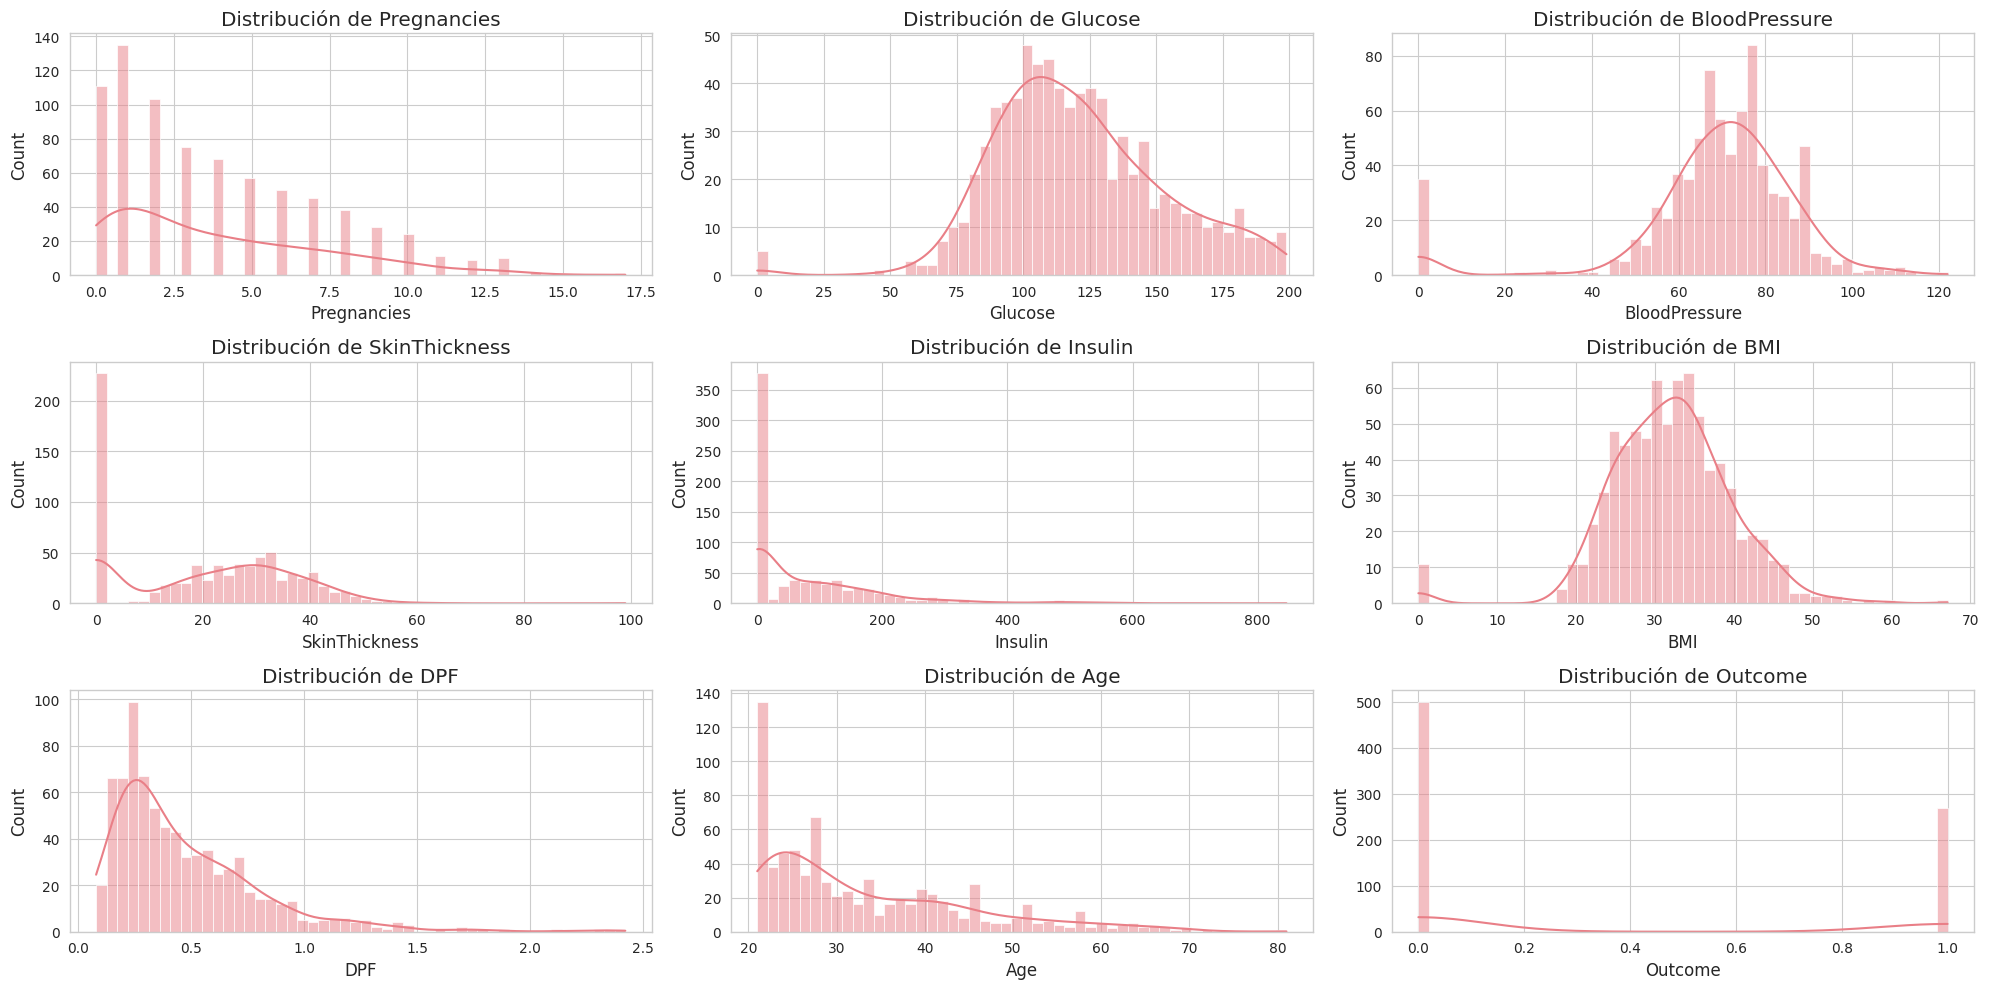

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] INFORMACIÓN ESTADÍSTICA DE LAS VARIABLES [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

print(Panel(f"[bold {COLOR_PANEL}]1) Estadística descriptiva[/bold {COLOR_PANEL}]"))
display(df_diabetes.describe())

print(Panel(f"[bold {COLOR_PANEL}]2) Histogramas de distribución[/bold {COLOR_PANEL}]"))
# Para cada uno de los valores numéricos crearemos un histograma
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))

for i,atributo in enumerate(df_diabetes.columns):
    plt.subplot(3,3,i + 1)
    sns.histplot(data=df_diabetes, x=atributo,bins=50, color= COLOR_CEMP, kde=True)
    plt.title(f"Distribución de {atributo}")
plt.tight_layout()
plt.show()

Algo que llama la atención en estas distribuciones, es el hecho de que en las características **"Glucose", "BloodPressure", "SkinThickness", "Insuline" y "BMI"** aparecen numerosos registros con un **valor 0**, lo que resulta fisiológicamente inviable.

Por tanto, aunque anteriormente no hemos observado valores NA, estos valores 0 en las variables mencionadas hacen referencia a valores ausentes que han sido codificados incorrectamente.


────────────────────────────────  INFORMACIÓN ESTADÍSTICA DE LAS VARIABLES SIN 0  ─────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 1) Estadística descriptiva sin 0s anómalos                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   763.00         733.00         541.00   394.00  757.00   
mean          3.85   121.69          72.41          29.15   155.55   32.46   
std           3.37    30.54          12.38          10.48   118.78    6.92   
min           0.00    44.00          24.00           7.00    14.00   18.20   
25%           1.00    99.00          64.00          22.00    76.25   27.50   
50%           3.00   117.00          72.00          29.00   125.00   32.30   
75%           6.00   141.00          80.00          36.00   190.00   36.60   
max          17.00   199.00         122.00          99.00   846.00   67.10   

          DPF     Age  Outcome  
count  768.00  768.00   768.00  
mean     0.47   33.24     0.35  
std      0.33   11.76     0.48  
min      0.08   21.00     0.00  
25%      0.24   24.00     0.00  
50%      0.37   29.00     0.00  
75%      0.63   41.00     1.00  
max      2.42   81.00     1.00

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 2) Histogramas de distribución sin 0s anómalos                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

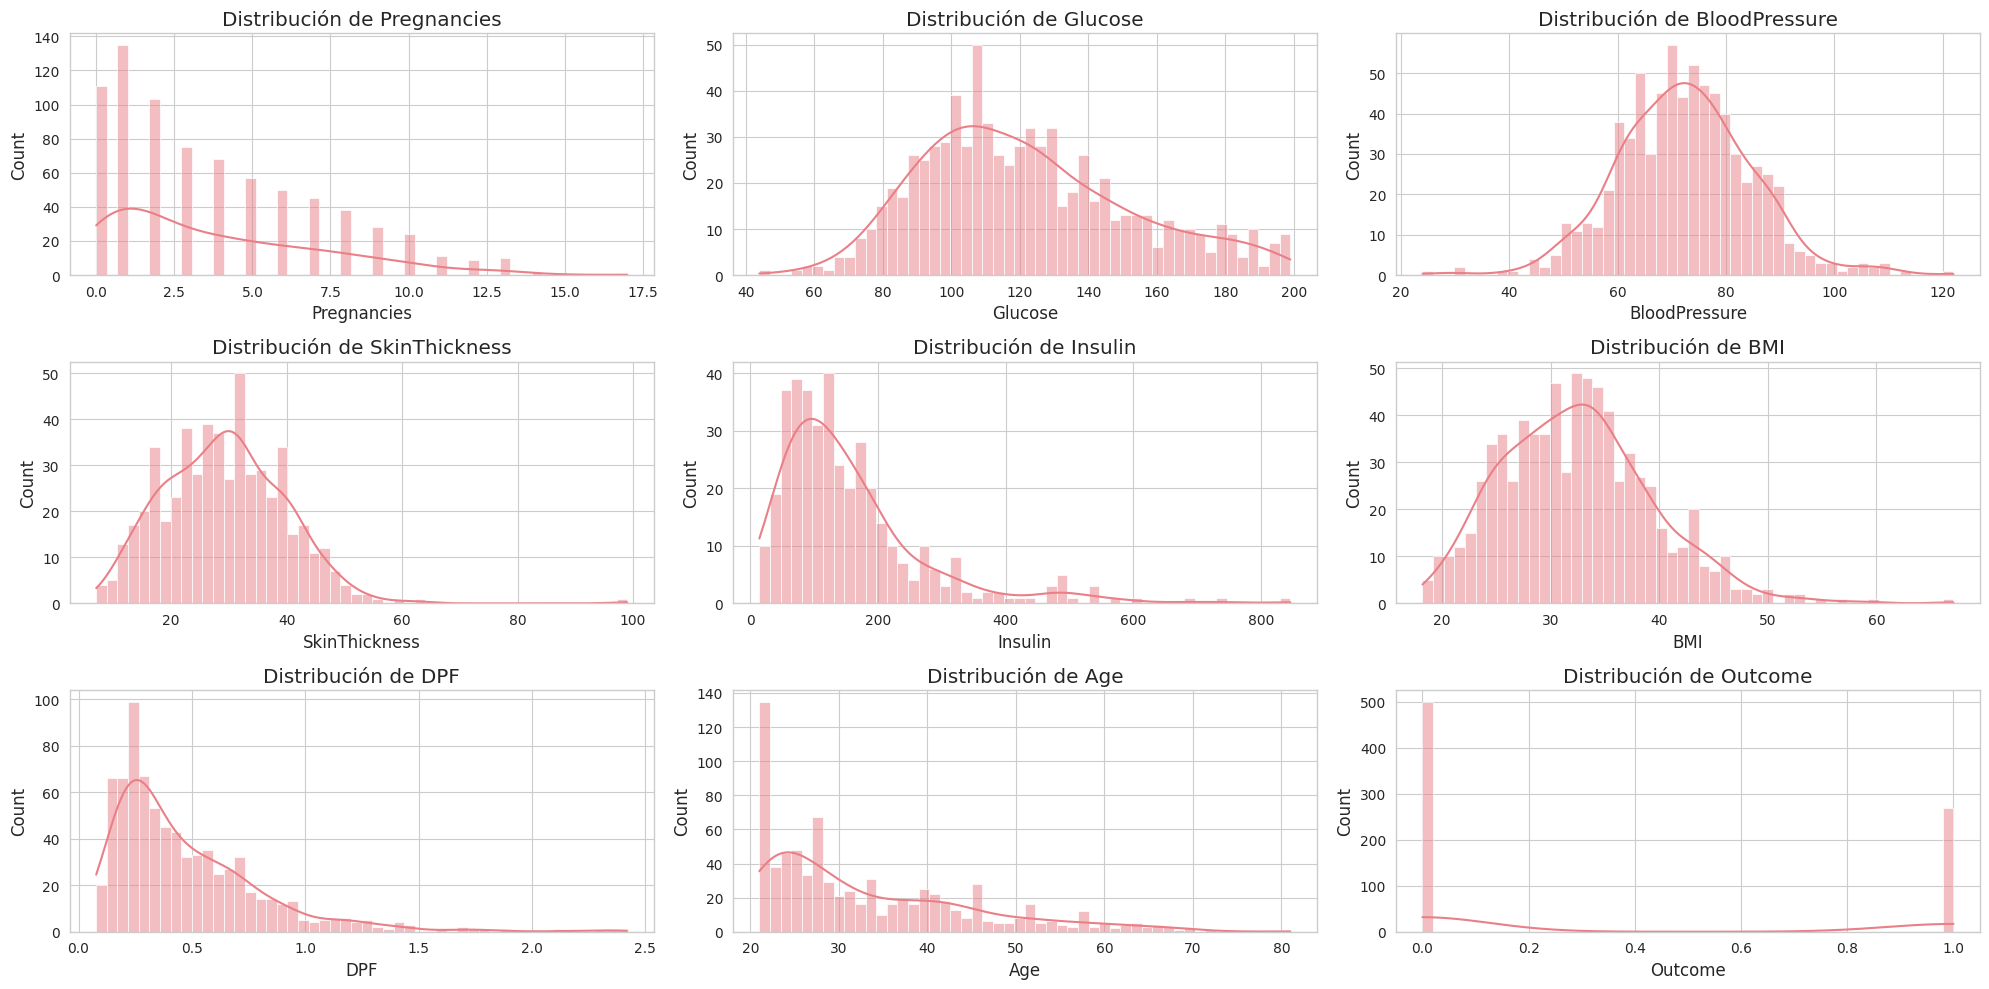

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 3) Histogramas de distribución según Outcome                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

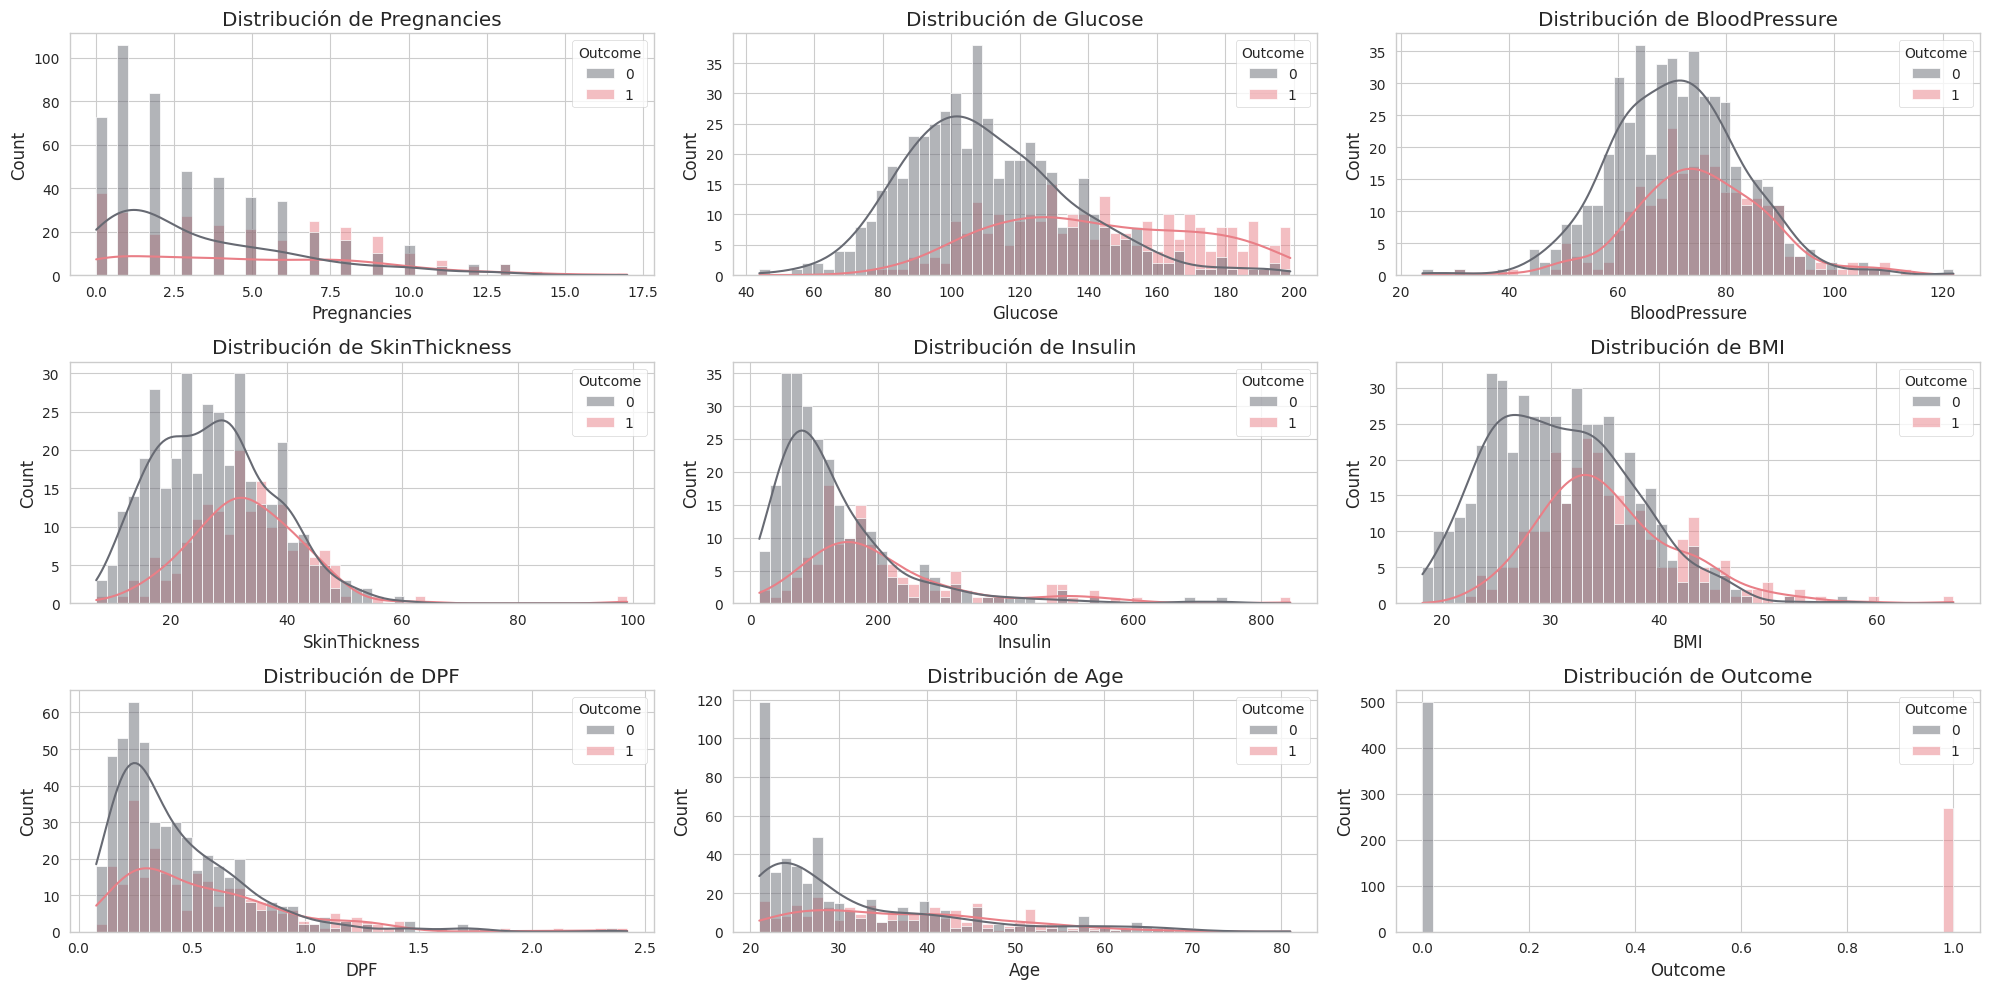

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] INFORMACIÓN ESTADÍSTICA DE LAS VARIABLES SIN 0 [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

# Convertimos valores 0 en NA para que no se tengan en cuenta en los análisis estadísticos
columnas_0 = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df_diabetes_NA = df_diabetes.copy()
df_diabetes_NA[columnas_0] = df_diabetes_NA[columnas_0].replace(0, np.nan)


print(Panel(f"[bold {COLOR_PANEL}]1) Estadística descriptiva sin 0s anómalos[/bold {COLOR_PANEL}]"))
display(df_diabetes_NA.describe().round(2))

print(Panel(f"[bold {COLOR_PANEL}]2) Histogramas de distribución sin 0s anómalos[/bold {COLOR_PANEL}]"))
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
for i,atributo in enumerate(df_diabetes_NA.columns):
    plt.subplot(3,3,i + 1)
    sns.histplot(data=df_diabetes_NA, x=atributo,bins=50, color= COLOR_CEMP, kde=True)
    plt.title(f"Distribución de {atributo}")
plt.tight_layout()
plt.show()

print(Panel(f"[bold {COLOR_PANEL}]3) Histogramas de distribución según Outcome [/bold {COLOR_PANEL}]"))
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
for i,atributo in enumerate(df_diabetes_NA.columns):
    plt.subplot(3,3,i + 1)
    sns.histplot(data=df_diabetes_NA, x=atributo,hue="Outcome", bins=50, palette= paleta_colores, kde=True)
    plt.title(f"Distribución de {atributo}")
plt.tight_layout()
plt.show()

──────────────────────────────────────────────  MISSING VALUES (NA)  ──────────────────────────────────────────────

El dataset contiene un número total de 768 filas

NA   % NA     Tipo
Insulin        374  48.70  float64
SkinThickness  227  29.56  float64
BloodPressure   35   4.56  float64
BMI             11   1.43  float64
Glucose          5   0.65  float64

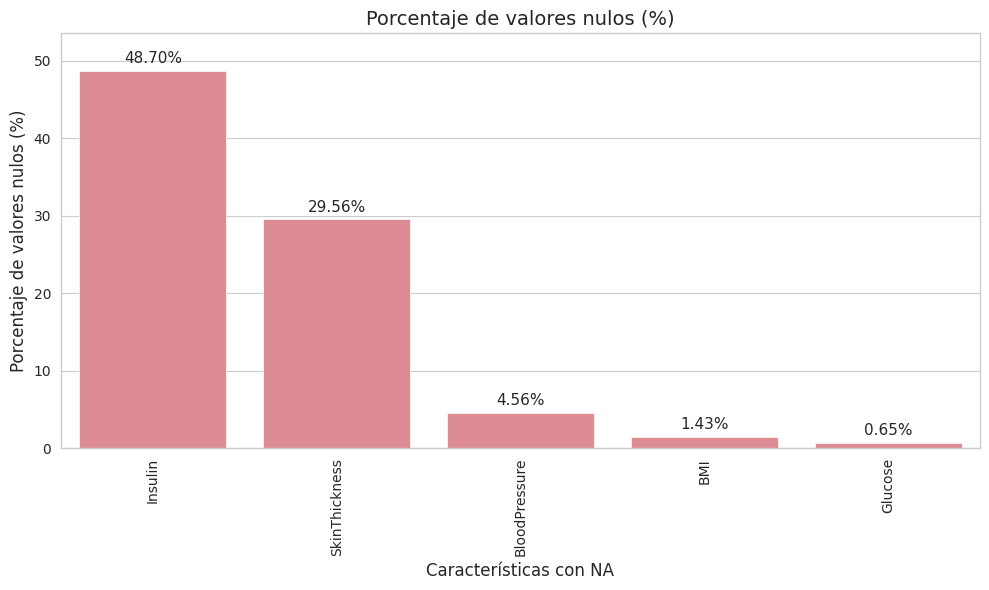

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] MISSING VALUES (NA) [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
#1) Número total de filas (para sacar % NA)
n_filas_NA = df_diabetes_NA.shape[0]

#2) Número de NA por columna
columnas_NA= df_diabetes_NA.columns[df_diabetes_NA.isna().any()] #filtramos aquellas columnas que tengan al menos un valor nulo
numero_NA= df_diabetes_NA[columnas_NA].isna().sum() #sumamos el nº de NA para cada columna

#3) Porcentaje NA
porcentaje_NA = numero_NA/n_filas_NA * 100 #calculamos el % de NA para cada columna
porcentaje_NA = porcentaje_NA.round(2) #redondeamos a 2 decimales
porcentaje_NA_ordenado = porcentaje_NA.sort_values(ascending=False)
#Tipo de datos de columnas con NA
tipo_dato= df_diabetes_NA[columnas_NA].dtypes

print(f"El dataset contiene un número total de {n_filas_NA} filas\n")
display(pd.concat([numero_NA, porcentaje_NA, tipo_dato], axis=1, keys=["NA","% NA", "Tipo"]).sort_values(by="NA", ascending=False))

# GRÁFICO PORCENTAJE VALORES NA
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x=porcentaje_NA_ordenado.index, y=porcentaje_NA_ordenado.values, color= COLOR_CEMP)
plt.title("Porcentaje de valores nulos (%)", fontsize=14)
plt.xlabel("Características con NA")
plt.ylabel("Porcentaje de valores nulos (%)")
plt.xticks(rotation=90)
plt.ylim(0, max(porcentaje_NA.values) * 1.1) # Ajustamos el límite Y para dejar espacio al texto
for p in ax.patches:
    altura = p.get_height()
    # Añadimos el porcentaje en la parte superior central de la barra
    ax.text(
        p.get_x() + p.get_width() / 2.,
        altura + 1,
        '{:1.2f}%'.format(altura),
        ha='center',
        fontsize=11
    )
plt.tight_layout()
plt.show()

El **target**, se encuentra bastante desbalanceado, presentando un **menor número de pacientes con diabetes**. Este desbalance de clases para el atributo **Outcome**, deberá ser tratado.

Por ello, antes de entrenar nuestro modelo, para asegurar que el aprendizaje se realice correctamente, tendremos que aplicar alguna **estrategia que balancee las clases de nuestro target**. Podremos elegir entre sobremuestrear la clase menos representada (por ejemplo, utilizando SMOTE) o submuestrear la clase mayoritaria.

───────────────────────────────────────  INFORMACIÓN GLUCEMIA 2H POST-PTOG  ───────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 1) Histogramas de distribución rango glucosa]                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

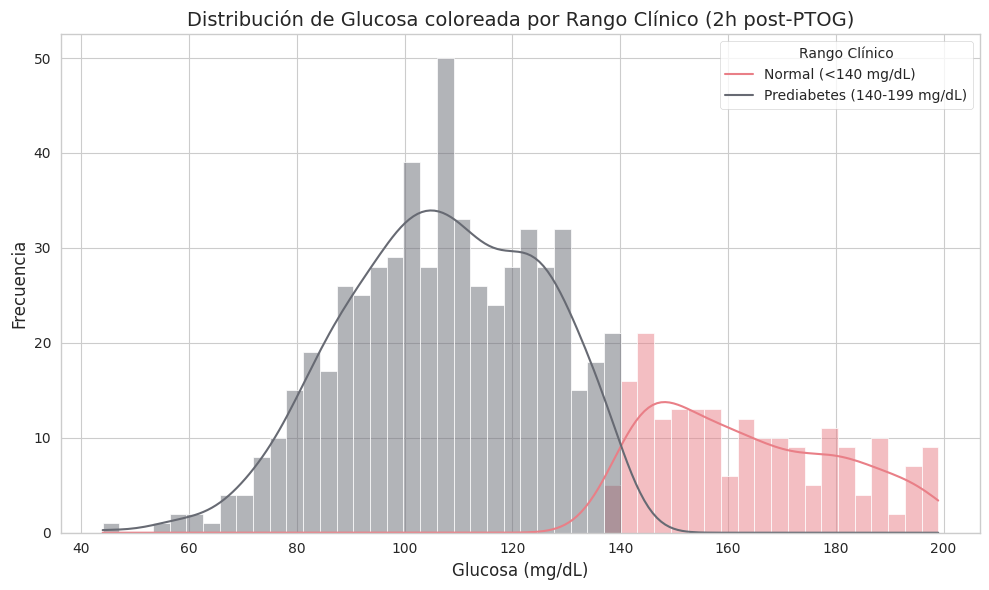

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 2) Tabla de contingencia: rango de glucosa vs outcome (1: Diabetes)                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Outcome                        0    1
Rango_glucosa                        
Normal (<140 mg/dL)          435  131
Prediabetes (140-199 mg/dL)   62  135

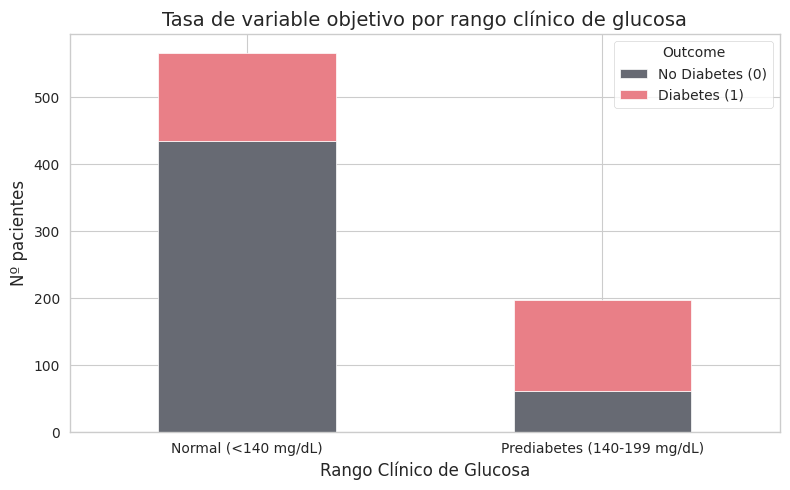

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] INFORMACIÓN GLUCEMIA 2H POST-PTOG [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

#Creamos una columna con los tres rangos de glucemia (<140, 140-199, >= 200)
df_rango_glucosa = df_diabetes_NA.copy()
bins = [df_rango_glucosa["Glucose"].min() - 1, 140, 200]
labels = ["Normal (<140 mg/dL)", "Prediabetes (140-199 mg/dL)"]
df_rango_glucosa["Rango_glucosa"] = pd.cut(df_rango_glucosa["Glucose"], bins=bins, labels=labels, right=False, include_lowest=True,)

# HISTOGRAMAS GLUCOSA
print(Panel(f"[bold {COLOR_PANEL}]1) Histogramas de distribución rango glucosa[/bold {COLOR_PANEL}]]"))
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_rango_glucosa, x="Glucose", hue="Rango_glucosa", palette=paleta_colores, bins=50, kde=True)
plt.title("Distribución de Glucosa coloreada por Rango Clínico (2h post-PTOG)", fontsize=14)
plt.xlabel("Glucosa (mg/dL)")
plt.ylabel("Frecuencia")
ax.legend(title="Rango Clínico", labels=["Normal (<140 mg/dL)", "Prediabetes (140-199 mg/dL)"])
plt.tight_layout()
plt.show()

# GLUCOSE VS OUTCOME
print(Panel(f"[bold {COLOR_PANEL}]2) Tabla de contingencia: rango de glucosa vs outcome (1: Diabetes) [/bold {COLOR_PANEL}]"))
t_contingencia = pd.crosstab(df_rango_glucosa["Rango_glucosa"], df_rango_glucosa["Outcome"])
print(t_contingencia)

ax = t_contingencia.plot(kind="bar", stacked=True, figsize=(8, 5), color=paleta_colores)
plt.title("Tasa de variable objetivo por rango clínico de glucosa", fontsize=14)
plt.xlabel("Rango Clínico de Glucosa")
plt.ylabel("Nº pacientes")
plt.xticks(rotation=0)
ax.legend(title="Outcome", labels=["No Diabetes (0)", "Diabetes (1)"])
plt.tight_layout()
plt.show()

─────────────────────────────────────  RELACIÓN NIVELES GLUCOSA VS INSULINA  ──────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Gráfico de dispersión                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

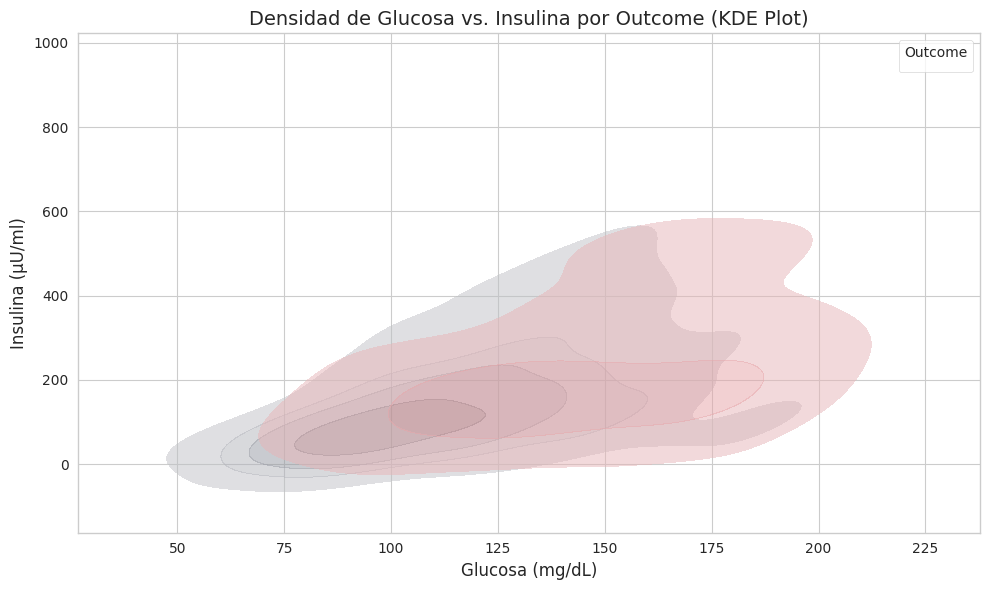

In [ ]:
palette_outcome = {0: COLOR_TITULOS, 1: COLOR_CEMP}
sns.set_style("whitegrid")

console.rule(f"[bold {COLOR_CEMP}] RELACIÓN NIVELES GLUCOSA VS INSULINA [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}] 1) Gráfico de dispersión [/bold {COLOR_PANEL}]"))
# ASUMIMOS el DataFrame df_diabetes_NA y las variables de color definidas

# ----------------------------------------------------------------------
# 1. GRÁFICO DE DENSIDAD KERNEL (KDE Plot): GLUCOSA vs. INSULINA
#    (Muestra la nube de probabilidad, ideal para datos densos)
# ----------------------------------------------------------------------

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_diabetes_NA.dropna(subset=['Glucose', 'Insulin']),
    x='Glucose',
    y='Insulin',
    hue='Outcome',
    palette=palette_outcome,
    fill=True,      # Rellena las áreas para mejor visualización
    alpha=.5,       # Transparencia de las nubes
    levels=5        # Número de niveles de contorno a dibujar
)
plt.title('Densidad de Glucosa vs. Insulina por Outcome (KDE Plot)', fontsize=14)
plt.xlabel('Glucosa (mg/dL)')
plt.ylabel('Insulina (µU/ml)')
plt.legend(title='Outcome', labels=['No Diabetes (0)', 'Diabetes (1)'])
plt.tight_layout()
plt.savefig("kdeplot_glucosa_insulina.png")
plt.show()

Para la población Pima no basta usar un solo valor de glucosa 2 h (OGTT) como predictor de diabetes. Hay una gran heterogeneidad metabólica: resistencia a insulina, secreción de insulina, obesidad, antecedentes familiares, etc. — muchos individuos con glucosa “normal/prediabetes” ya tienen diabetes según criterios clínicos más amplios. Esto destaca la necesidad de usar modelos multivariables (no solo glucosa) para predecir o diagnosticar en poblaciones con alto riesgo/genética fuerte, como los Pima.

──────────────────────────────────  RELACIONES ENTRE LOS ATRIBUTOS DEL DATASET  ───────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Mapa de correlación de todas las variables                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

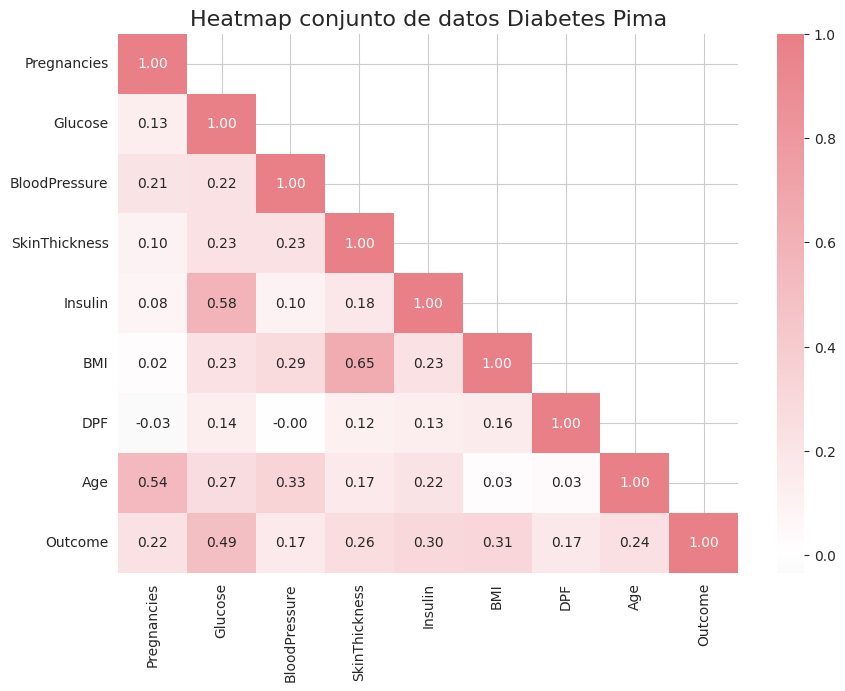

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  2) Pairplot en función de Outcome                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

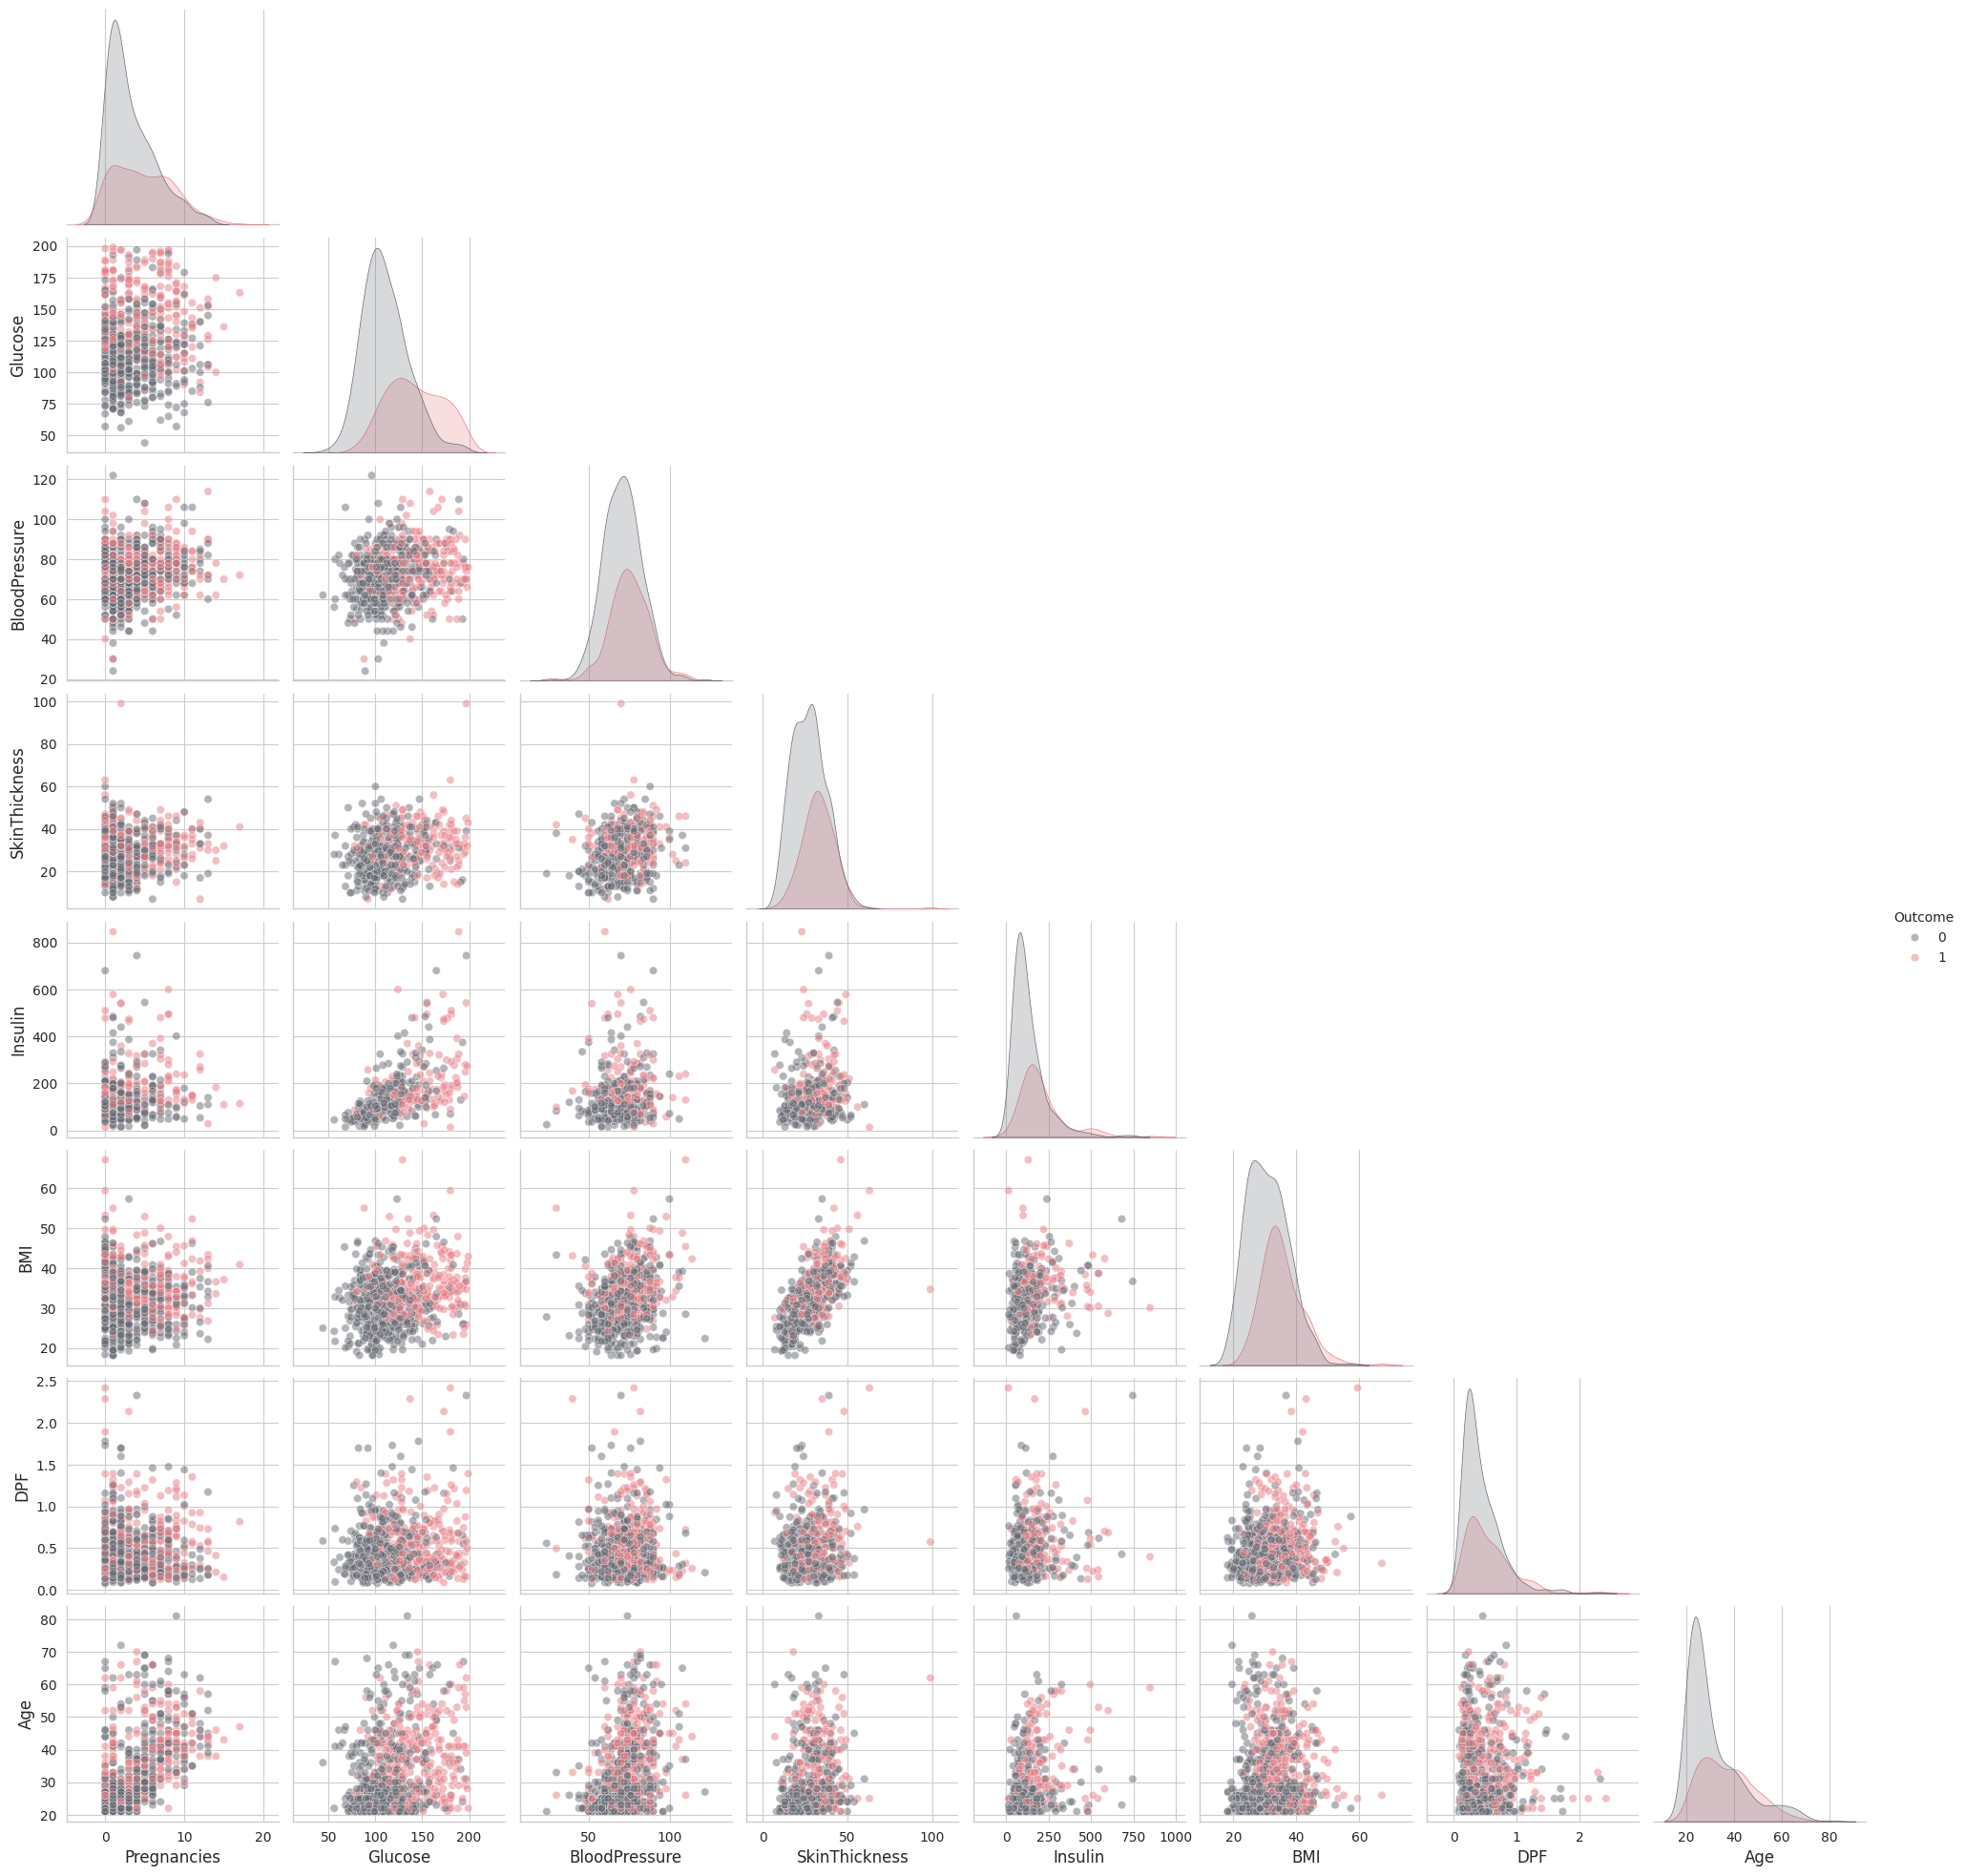

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] RELACIONES ENTRE LOS ATRIBUTOS DEL DATASET [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

print(Panel(f"[bold {COLOR_PANEL}] 1) Mapa de correlación de todas las variables [/bold {COLOR_PANEL}]"))
# Mostraremos la mitad de la matriz de correlación para evitar valores redundantes
correlation_matrix = df_diabetes_NA.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(10, 7))

#Elaboramos mitad mapa con colores degradados desde COLOR_TITULOS hasta COLOR_CEMP
sns.heatmap(correlation_matrix, mask = mask, annot=True, cmap=cmap_personalizado, center = 0, fmt=".2f")
plt.title("Heatmap conjunto de datos Diabetes Pima", fontsize=16)
plt.show()

print(Panel(f"[bold {COLOR_PANEL}] 2) Pairplot en función de Outcome [/bold {COLOR_PANEL}]"))
sns.pairplot(df_diabetes_NA, hue="Outcome", palette = paleta_colores, corner=True, plot_kws={'alpha':0.5})
plt.show()


Se ha mostrado únicamente la mitad inferior de la matriz de correlación para evitar la redundancia, ya que, es simétrica.

**Estudiar el tipo de relaciones lineales/no lineales**

Como hemos mencionado anteriormente, las correlaciones lineales con la variable objetivo Outcome (máximo 0.49 con Glucose) no son extremadamente fuertes. Sin embargo, la **diabetes es una enfermedad clínicamente compleja que implica interacciones y relaciones no lineales** entre múltiples factores, lo cual justificamos a continuación con el pairplot.

- Por tanto, dadas las correlaciones obtenidas mediante el heatmap y estas relaciones complejas, se necesitará: **Aplicar modelos de clasificación no lineales** (ej., Support Vector Machines con kernel no lineal, Random Forest o Redes Neuronales) para capturar las interacciones.

- Combinar **múltiples variables** (mediante feature engineering o la propia naturaleza de los modelos no lineales) para mejorar la capacidad predictiva del modelo que empleemos.

- Otro dato interesante que se visualiza gracias al pairplot es la presencia de **puntos aislados lejos de la nube de datos principal**, especialmente en relación con Insulin y SkinThickness. Estos corresponden a valores atípicos (outliers) y serán tratados en detalle en la **fase de preprocesamiento**, ya que pueden sesgar el entrenamiento de los modelos.

──────────────────────────────────────────  IDENTIFICACIÓN DE OUTLIERS  ───────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Boxplots variables numéricas                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

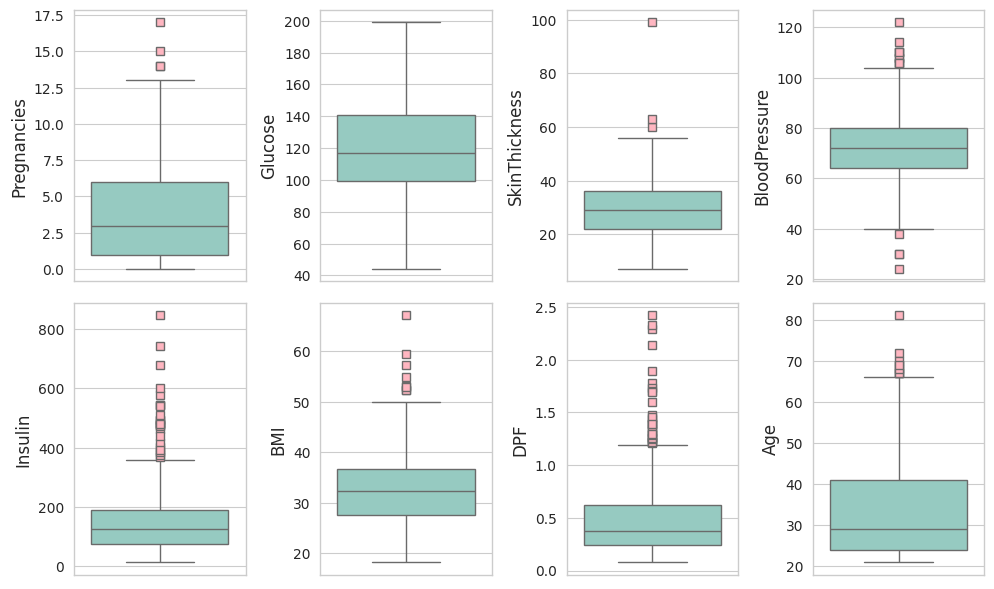

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  2) Boxplots variables numéricas en función de Outcome                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

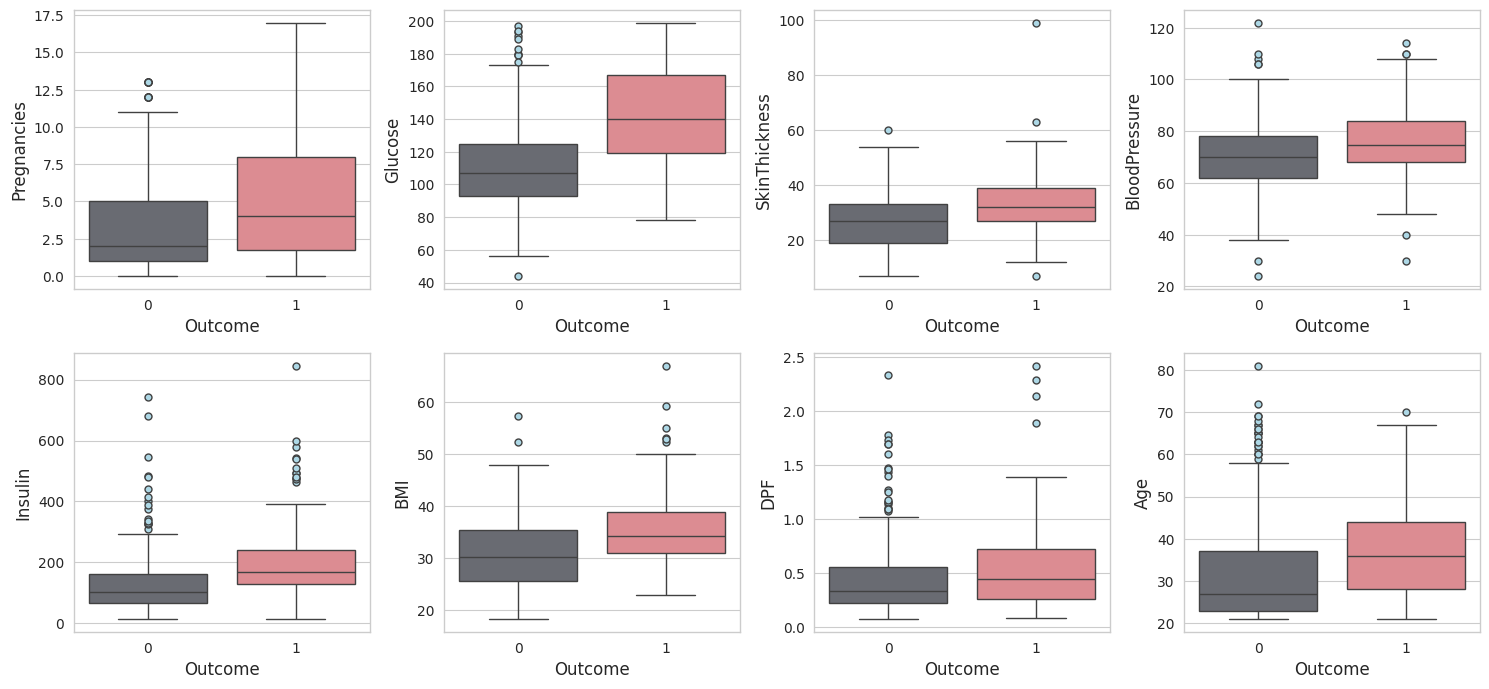

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] IDENTIFICACIÓN DE OUTLIERS [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
# Variables continuas (todos menos los dos últimos)
variables_numericas_update = ["Pregnancies", "Glucose", "SkinThickness","BloodPressure", "Insulin", "BMI", "DPF", "Age"]

# BOXPLOTS VARIABLES NUMÉRICAS
print(Panel(f"[bold {COLOR_PANEL}] 1) Boxplots variables numéricas [/bold {COLOR_PANEL}]"))
plt.figure(figsize=(10, 6))
for i, atributo in enumerate(variables_numericas_update, 1):
    plt.subplot(2,4, i)
    sns.boxplot(y=df_diabetes_NA[atributo], palette="Set3", flierprops=dict(marker="s", markerfacecolor="lightpink"))
    plt.xlabel("") # Ocultar etiqueta X redundante
plt.tight_layout()
plt.show()


# BOXPLOTS VARIABLES NUMÉRICAS EN FUNCIÓN DE OUTCOME
print(Panel(f"[bold {COLOR_PANEL}] 2) Boxplots variables numéricas en función de Outcome [/bold {COLOR_PANEL}]"))
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")
for i, atributo in enumerate(variables_numericas_update, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x="Outcome", y=df_diabetes_NA[atributo], data=df_diabetes_NA, palette=paleta_colores, flierprops=dict(marker="o", markerfacecolor="lightblue", markersize=5))
    plt.xlabel("Outcome")
plt.tight_layout()
plt.show()

### **4.- Preprocesamiento datos**

En este bloque se llevará a cabo el procesamiento de datos. En este, se realizará:

1) **Limpieza de datos**:
- Corrección de valores imposibles (como los 0s anteriores) a NaN.
- Eliminacion de variables redundantes.


2) **División en conjuntos de entrenamiento**: entrenamiento/validación/prueba de forma estratificada.


3) **Preprocesamiento de datos conjunto de train**:
- Tratamiento de valores nulos.
- Detección y eliminación de outilers.
- Balanceo del conjunto de entrenamiento, con el fin de solventar el problema de la desproporción de clases en Outcome.

4) **Escalado de los atributos**: para garantizar una distribución adecuada.

5) **Selección de características**: para reducir la dimensionalidad y mejorar el rendimiento del modelo.
En esta sección se hará uso de:
- SelectKBest

  De esta manera, posteriormente, se comparará el rendimiento del modelo en función de las características seleccionadas por cada método.

##### **4.1.- Limpieza de datos**

Durante la visualización de los datos, se ha llevado a cabo la transformación de los 0 a valores NaN.

###### **a) Eliminación de variables redundantes**

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] FEATURE ENGINEERING [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
#1) Eliminamos variable redundande debido a alta multicolinealidad y menor aporte predictivo
df_diabetes_sin_redundantes = df_diabetes_NA.drop(columns=["SkinThickness"])
print(df_diabetes_sin_redundantes.columns)

──────────────────────────────────────────────  FEATURE ENGINEERING  ──────────────────────────────────────────────

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF',
       'Age', 'Outcome'],
      dtype='object')

##### **4.2.- División en conjuntos de entrenamiento, validación, y prueba (training, validation, test):**

In [ ]:
#SEPARAMOS EL CONJUNTO DE DATOS en ATRIBUTOS (X) Y TARGET (y)
X = df_diabetes_sin_redundantes.drop("Outcome", axis=1)
y = df_diabetes_sin_redundantes["Outcome"]

# Dividimos conjunto 80% entrenamiento y evaluación, 20% para test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] 1) DIVISIÓN CONJUNTOS: TRAIN Y TEST SIN OUTLIERS [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

print(Panel(f"[bold {COLOR_PANEL}] A) Tamaño [/bold {COLOR_PANEL}]"))
print(f"- Tamaño del conjunto Train / Val (80%): {X_train_val.shape[0]} filas y {X_train_val.shape[1]} columnas")
print(f"- Tamaño del conjunto Test (20%): {X_test.shape[0]} filas y {X_test.shape[1]} columnas")

print(Panel(f"[bold {COLOR_PANEL}] B) Proporción de clase 1 [/bold {COLOR_PANEL}]"))
proporcion_total = y.value_counts(normalize=True) * 100
print(f"- Conjunto total: {proporcion_total[1]:.2f}%")

proporcion_train_val = y_train_val.value_counts(normalize=True) * 100
print(f"- Conjunto Train/Val: {proporcion_train_val[1]:.2f}%")

proporcion_test = y_test.value_counts(normalize=True) * 100
print(f"- Conjunto Test: {proporcion_test[1]:.2f}%")

───────────────────────────────  1) DIVISIÓN CONJUNTOS: TRAIN Y TEST SIN OUTLIERS  ────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  A) Tamaño                                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Tamaño del conjunto Train / Val (80%): 614 filas y 7 columnas

- Tamaño del conjunto Test (20%): 154 filas y 7 columnas

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  B) Proporción de clase 1                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Conjunto total: 34.90%

- Conjunto Train/Val: 34.85%

- Conjunto Test: 35.06%

##### **4.3.- Preprocesamiento de datos conjunto de train**:

A partir de este punto, para evitar el Data Leakage, todo el preprocesamiento de datos  se realizará únicamente a partir del conjunto de entrenamiento (X_train_val). Posteriormente, las mismas transformaciones se aplicarán al conjunto de test utilizando los parámetros aprendidos del train.

###### **a) Tratamiento de valores nulos (NA)**

In [ ]:
# Columnas con NA (sin tener encuenta SkinThickness que ha sido eliminada)
columnas_NA_train = X_train_val.columns[X_train_val.isna().any()].tolist()
print(f"Columnas con NA: {columnas_NA_train}")

Columnas con NA: ['Glucose', 'BloodPressure', 'Insulin', 'BMI']

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] MEDIA Y MEDIANA IMPUTACIÓN NA [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

# Calculamos media y mediana únicamente sobre X_train_val
metricas_calculadas = X_train_val[columnas_NA_train].agg(["mean", "median"]).T
df_metrics = metricas_calculadas.rename(columns={"mean": "Media", "median": "Mediana"})
df_metrics = df_metrics.reset_index().rename(columns={"index": "Variable"})

#Cogemos los primeros dos decimales
df_metrics["Media"] = df_metrics["Media"].round(2)
df_metrics["Mediana"] = df_metrics["Mediana"].round(2)

# Trasponemos la tabla: las filas -> columnas, columnas -> filas
df_metrics = df_metrics.set_index("Variable").T
display(df_metrics)

─────────────────────────────────────────  MEDIA Y MEDIANA IMPUTACIÓN NA  ─────────────────────────────────────────

Variable  Glucose  BloodPressure  Insulin    BMI
Media       121.7          72.15   149.08  32.45
Mediana     117.0          72.00   125.00  32.40

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] IMPUTACIÓN NA CON MEDIANA[/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

imputer = SimpleImputer(strategy="median")
# Imputamos usando la mediana del conjunto final de entrenamiento (fit_transform)
X_train_val_sin_NA = pd.DataFrame(imputer.fit_transform(X_train_val), columns=X_train_val.columns, index=X_train_val.index)
# Imputamos con la mediana calculada anteriormente, para evitar mirar datos de test (solo transform)
X_test_sin_NA = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

# Comprobamos que ya no hay valores nulos
print(Panel(f"[bold {COLOR_PANEL}] 1) Comprobación [/bold {COLOR_PANEL}]"))
print(f"- Cantidad NA conjunto train_val: \n {X_train_val_sin_NA.isna().sum()} \n")
print(f"- Cantidad NA conjunto test: \n {X_test_sin_NA.isna().sum()}")

# Medias y medias antes y después de imputación
print(Panel(f"[bold {COLOR_PANEL}] 2) Medias y medianas antes y después imputación [/bold {COLOR_PANEL}]"))
metricas_antes = X_train_val[columnas_NA_train].agg(["mean", "median"])
metricas_antes = metricas_antes.T.rename(columns={"mean": "media_antes", "median": "Mediana_antes"})

metricas_despues = X_train_val_sin_NA[columnas_NA_train].agg(["mean", "median"])
metricas_despues = metricas_despues.T.rename(columns={"mean": "media_despues", "median": "Mediana_despues"})

df_comparacion_imputacion = pd.concat([metricas_antes, metricas_despues], axis=1).round(2)
display(df_comparacion_imputacion)

───────────────────────────────────────────  IMPUTACIÓN NA CON MEDIANA ────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Comprobación                                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Cantidad NA conjunto train_val: 
 Pregnancies      0
Glucose          0
BloodPressure    0
Insulin          0
BMI              0
DPF              0
Age              0
dtype: int64

- Cantidad NA conjunto test: 
 Pregnancies      0
Glucose          0
BloodPressure    0
Insulin          0
BMI              0
DPF              0
Age              0
dtype: int64

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  2) Medias y medianas antes y después imputación                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

media_antes  Mediana_antes  media_despues  Mediana_despues
Glucose             121.70          117.0         121.67            117.0
BloodPressure        72.15           72.0          72.14             72.0
Insulin             149.08          125.0         137.71            125.0
BMI                  32.45           32.4          32.45             32.4

Como podemos observar se ha realizado correctamente la imputación de los valores nulos.

Se puede observar cómo la estrategia conservó la Mediana (el valor más representativo de la tendencia central) mientras mejoró la calidad de la Media al mitigar el impacto de los valores atípicos.

###### **c) Creación de nuevas variables (Feature Engineering)**

En este apartado, crearemos nuevas variables como:
- **Indice_resistencia**: que se calculará mediante el producto del valor Glucose x Insulin. Un valor alto en este índice indicará un páncreas que está trabajando en exceso para controlar los niveles de glucosa.

- **BMI^2**: mostrará el riesgo No Lineal por obesidad al penalizar de manera exponencial la obsedidad severa.

- **Is_prediabetes**: introduce el umbral clínico de 140 mg/dL a partir del cual existe prediabetes

In [ ]:
# Sobre X_train_val_sin_NA
X_train_val_sin_NA["Indice_resistencia"] = X_train_val_sin_NA["Glucose"] * X_train_val_sin_NA["Insulin"]
X_train_val_sin_NA["BMI_square"] = X_train_val_sin_NA["BMI"] ** 2
X_train_val_sin_NA["Is_prediabetes"] = (X_train_val_sin_NA["Glucose"] >= 140).astype(int)

# Sobre X_test_sin_NA
X_test_sin_NA["Indice_resistencia"] = X_test_sin_NA["Glucose"] * X_test_sin_NA["Insulin"]
X_test_sin_NA["BMI_square"] = X_test_sin_NA["BMI"] ** 2
X_test_sin_NA["Is_prediabetes"] = (X_test_sin_NA["Glucose"] >= 140).astype(int)

A continuación, uniremos los 4 conjuntos de datos separados anteriormente en 80-20, para visualizar el conjunto de datos completo con estas nuevas variables. En caso de obtener algún gráfico de interés.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) DF con Nuevas variables                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Dimensiones:(768, 11)

Pregnancies  Glucose  BloodPressure  Insulin   BMI    DPF   Age  \
353          1.0     90.0           62.0     43.0  27.2  0.580  24.0   
711          5.0    126.0           78.0     22.0  29.6  0.439  40.0   
373          2.0    105.0           58.0     94.0  34.9  0.225  25.0   
46           1.0    146.0           56.0    125.0  29.7  0.564  29.0   
682          0.0     95.0           64.0    105.0  44.6  0.366  22.0   

     Indice_resistencia  BMI_square  Is_prediabetes  Outcome  
353              3870.0      739.84               0        0  
711              2772.0      876.16               0        0  
373              9870.0     1218.01               0        0  
46              18250.0      882.09               1        0  
682              9975.0     1989.16               0        0

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 2) Histogramas de distribución según Outcome                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

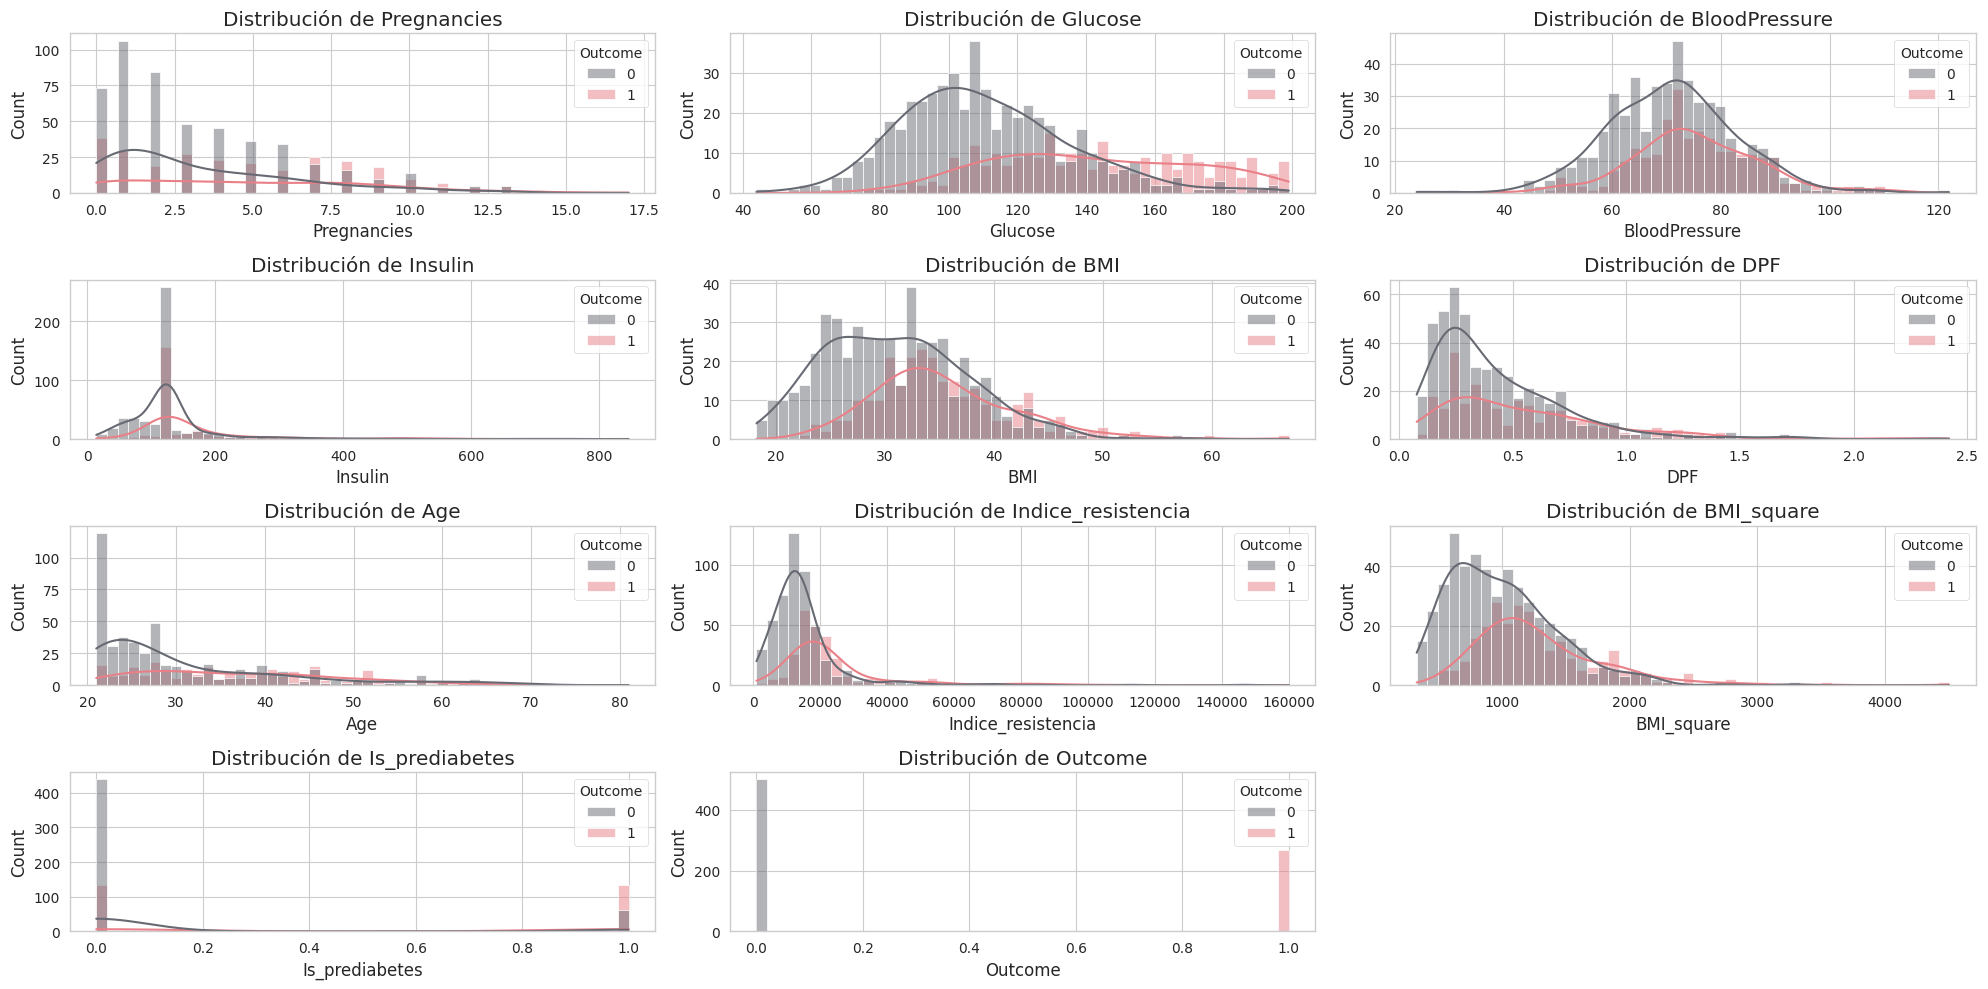

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  3) Mapa de correlación de todas las variables                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

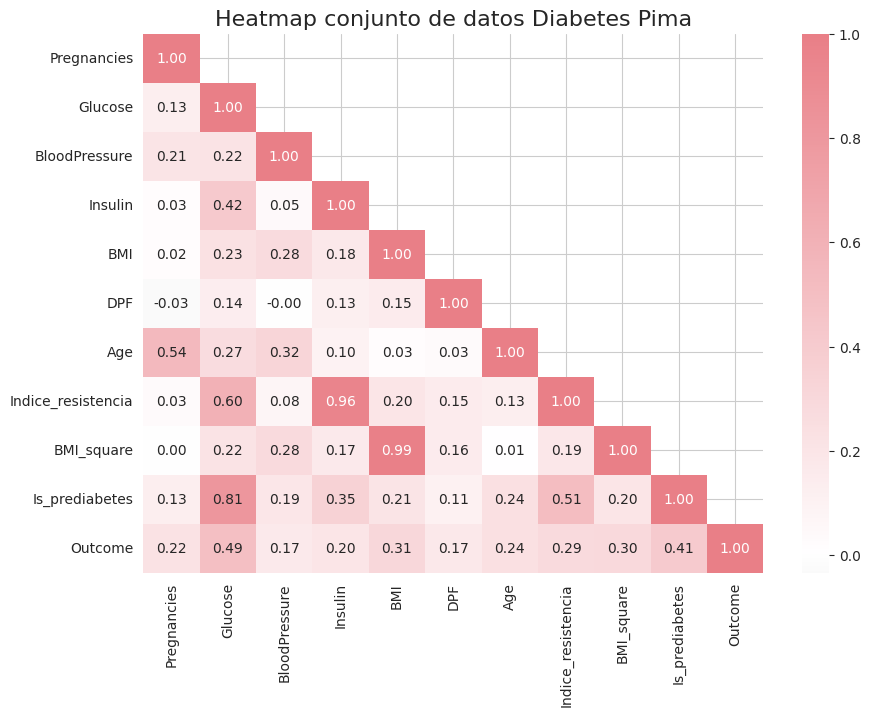

In [ ]:
print(Panel(f"[bold {COLOR_PANEL}] 1) DF con Nuevas variables [/bold {COLOR_PANEL}]"))
df_diabetes_nuevo = pd.concat([X_train_val_sin_NA, X_test_sin_NA], axis=0)
df_diabetes_nuevo["Outcome"] = pd.concat([y_train_val, y_test], axis=0)

print(f"- Dimensiones:{df_diabetes_nuevo.shape}")
display(df_diabetes_nuevo.head(5))

print(Panel(f"[bold {COLOR_PANEL}]2) Histogramas de distribución según Outcome [/bold {COLOR_PANEL}]"))
# Para cada uno de los valores numéricos crearemos un histograma
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
for i,atributo in enumerate(df_diabetes_nuevo.columns):
    plt.subplot(4,3,i + 1)
    sns.histplot(data=df_diabetes_nuevo, x=atributo,hue="Outcome", bins=50, palette= paleta_colores, kde=True)
    plt.title(f"Distribución de {atributo}")
plt.tight_layout()
plt.show()

print(Panel(f"[bold {COLOR_PANEL}] 3) Mapa de correlación de todas las variables [/bold {COLOR_PANEL}]"))
correlation_matrix = df_diabetes_nuevo.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, mask = mask, annot=True, cmap=cmap_personalizado, center = 0, fmt=".2f")
plt.title("Heatmap conjunto de datos Diabetes Pima", fontsize=16)
plt.show()

###### **d) Identificación y eliminación de outliers**

Aun así, consideraremos eliminar los más extremos.

Vamos a usar la **técnica de Interquartiles (IQR) para eliminar estos outliers**. Para evitar errores excluimos
las variables de atributos binarios (solo toman valores en 0 y 1) o numéricos. Si se intentan borrar todos los outliers a la vez, tomando estos estos valores, se borran todas las instancias.

**"Cuando los valores atípicos están más allá de 3 veces el RIC en lugar del 1.5 son denominados valores extremos."**

────────────────────────────────────  ELIMINACIÓN DE LOS VALORES MÁS EXTREMOS  ────────────────────────────────────

- Tamaño conjunto train ANTES de eliminar outliers: (614, 10)

- Tamaño conjunto train DESPUÉS de eliminar outliers: (395, 10)

-> Se han eliminado un número total de  219 filas.

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Comprobación a partir de boxplots                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

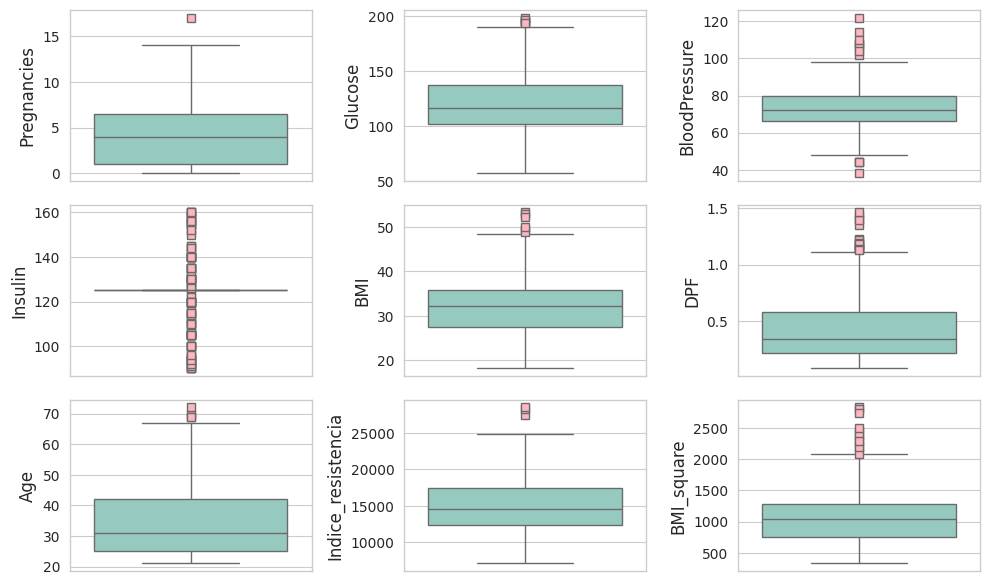

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] ELIMINACIÓN DE LOS VALORES MÁS EXTREMOS [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)

variables_numericas_update = ["Pregnancies", "Glucose", "BloodPressure", "Insulin", "BMI", "DPF", "Age", "Indice_resistencia", "BMI_square"]
X_train_val_outliers = X_train_val_sin_NA.copy()
y_train_val_outliers = y_train_val.copy()

UMBRAL_IQR = 3
for atributo in variables_numericas_update:
    # Calculamos los cuartiles e IQR
    q1 = X_train_val_outliers[atributo].quantile(0.25)
    q3 = X_train_val_outliers[atributo].quantile(0.75)
    iqr = q3 - q1

    # Límites para el Outlier Extremo (3 * IQR)
    limite_inferior = q1 - UMBRAL_IQR * iqr
    limite_superior = q3 + UMBRAL_IQR * iqr

    mask = (X_train_val_outliers[atributo] >= limite_inferior) & (X_train_val_outliers[atributo] <= limite_superior)
    X_train_val_outliers = X_train_val_outliers[mask]
    y_train_val_outliers = y_train_val_outliers[mask]


print(f"- Tamaño conjunto train ANTES de eliminar outliers: {X_train_val_sin_NA.shape}")
print(f"- Tamaño conjunto train DESPUÉS de eliminar outliers: {X_train_val_outliers.shape}")
print(f"\n -> Se han eliminado un número total de [bold] {X_train_val_sin_NA.shape[0]-X_train_val_outliers.shape[0]} filas.")

# VISUALIZACIÓN
print(Panel(f"[bold {COLOR_PANEL}] Comprobación a partir de boxplots [/bold {COLOR_PANEL}]"))
plt.figure(figsize=(10, 6))
for i, atributo in enumerate(variables_numericas_update, 1):
    plt.subplot(3,3, i)
    sns.boxplot(y=X_train_val_outliers[atributo], palette="Set3", flierprops=dict(marker="s", markerfacecolor="lightpink"))
    plt.xlabel("") # Ocultar etiqueta X redundante
plt.tight_layout()
plt.show()

Se han eliminado los outliers más extremos correctamente, aun así existen valores atípicos. **Esto es normal porque, en datos clínicos reales, algunas variables pueden presentar valores extremos** que, aunque poco comunes, reflejan casos auténticos y clínicamente posibles. Estos valores pueden contener información valiosa sobre **pacientes con condiciones severas o poco frecuentes**.

**Desbalanceo de clases**

Como vimos y se puede observar en la proporión de clase 1 anterior, uno de los grandes problemas del presente conjunto de datos era el notable **desbalanceo de la variable objetivo Outcome**.

In [ ]:
# Porcentaje de diferencia entre los sujetos con diabetes y sin diabetes
console.rule(f"[bold {COLOR_CEMP}] DESBALANCEO OUTCOME  [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}] A) CONJUNTO CON OUTLIERS [/bold {COLOR_PANEL}]"))
print(y_train_val.value_counts(normalize=True).map("{:.2%}".format))
print("\n")
print(Panel(f"[bold {COLOR_PANEL}] B) CONJUNTO SIN OUTLIERS [/bold {COLOR_PANEL}]"))
print(y_train_val_outliers.value_counts(normalize=True).map("{:.2%}".format))

─────────────────────────────────────────────  DESBALANCEO OUTCOME   ──────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  A) CONJUNTO CON OUTLIERS                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Outcome
0    65.15%
1    34.85%
Name: proportion, dtype: object

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  B) CONJUNTO SIN OUTLIERS                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Outcome
0    63.54%
1    36.46%
Name: proportion, dtype: object

##### **4.4.- Entrenamiento y validación**

Observamos, que las clases no estan distribuidas de forma equitativa.

Para saber si los siguientes modelos presentan un accuracy bueno o malo, consideraremos el accuracy que se obtendría de los dos modelos más básicos:



*  **Modelo al azar**: en este problema de clasificación binaria, el accuracy estaría próximo al 50% porque, en promedio, el modelo adivinará correctamente la clase aproximadamente la mitad de las veces.

*   **Modelo de la mayoría:** Si una clase es dominante (como ocurre con la de no sobrevivir (0), este modelo que siempre predice la clase mayoritaria obtendrá un alto accuracy simplemente porque está prediciendo la clase más común.

print(f"El accuracy que se obtendría con el modelo de la mayoría es de 0,65 cualquiera mayor significa que el modelo está mejorando la predicción.")

a) **Definición modelos de clasificación a aplicar**

In [ ]:
# DEFINIMOS LOS MODELOS A APLICAR PARA PREDECIR EL TARGET (OUTCOME)
console.rule(f"[bold {COLOR_CEMP}] MODELOS A APLICAR [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
modelos = {"Reg. Logística": LogisticRegression(solver="liblinear", max_iter=1000, random_state=42),
           "Random Forest": RandomForestClassifier(random_state=42),
           "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
           "SVM": SVC(probability=True, random_state=42),
           "MLP": MLPClassifier(max_iter=1000, random_state=42)}

print(f"Entre los modelos a aplicar encontramos: {list(modelos.keys())}")


# DEFINIMOS LOS DISTINTOS PARÁMETROS PARA LA BÚSQUEDA EXHAUSTIVA DE HIPERPARÁMETROS (GridSearchCV())
param_grids = {
    "Reg. Logística": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"],
        "model__class_weight": [None, "balanced"],
        "selector__k": [5, 7, 10]
    },

    "Random Forest": {
        "model__n_estimators": [100, 200],
        "model__max_depth": [5, 10, None],
        "model__min_samples_split": [2, 5],
        "model__class_weight": [None, "balanced"],
        "selector__k": ["all"]
    },

    "XGBoost": {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.05, 0.1, 0.3],
        "model__max_depth": [3, 5, 7],
        "selector__k": ["all"]
    },

    "SVM": {
        "model__C": [0.1, 1, 10],
        "model__kernel": ["rbf", "linear"],
        "model__gamma": ["scale", "auto"],
        "model__class_weight": [None, "balanced"],
        "selector__k": [5, 7, 10]
    },

    "MLP": {
        "model__hidden_layer_sizes": [(10,),(50,), (50, 50)],
        "model__alpha": [0.0001, 0.01],
        "model__activation": ["relu"],
        "model__learning_rate_init": [0.001, 0.01],
        "selector__k": [5, 7, 10]
    }


}

───────────────────────────────────────────────  MODELOS A APLICAR  ───────────────────────────────────────────────

Entre los modelos a aplicar encontramos: ['Reg. Logística', 'Random Forest', 'XGBoost', 'SVM', 'MLP']

b) **Definición funciones para correcto entrenamiento y validación**

In [ ]:
# FUNCIONES PARA ASEGURAR UN CORRECTO ENTRENAMIENTO Y VALIDACIÓN

def definir_pipeline(modelo_base, k_features=7, estrategia_balanceo=None):
  """
  Permite listar secuencialmente los pasos a seguir:
    1.- Balancear datos de train con SMOTE o SMOTE-ENN
    2.- Estandarizar los atributos a una media 0 y varianza 1
    3.- Seleccionar mejores características con SelectKBest
    4.- Aplicar modelo
  """
  steps = []
  if estrategia_balanceo == "SMOTE":
      steps.append(("smote", SMOTE(random_state=42)))

  steps.extend([
      ("scaler", StandardScaler()),
      ("selector", SelectKBest(score_func=f_classif, k=k_features)),
      ("model", modelo_base)
  ])
  return ImbPipeline(steps)



def optimizar_modelo(pipeline, X_train, y_train, param_grid):
  """
  Realiza la optimización del modelo usando GridSearchCV.
    - Prueba diferentes combinaciones de hiperparámetros.
    - Usa validación cruzada estratificada con 5 particiones.
    - Evalúa cada combinación usando la métrica F2.
    - Devuelve el mejor modelo encontrado.
  """
  cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  scorer = make_scorer(fbeta_score, beta = 2) #priorizamos recall sobre precision
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=param_grid,
      scoring=scorer,
      cv=cv_strategy,
      n_jobs=-1,
      verbose=0,
      return_train_score=True
  )
  grid_search.fit(X_train, y_train)
  return grid_search


def calcular_metricas(y_true, y_pred, y_probs):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F2": fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        "AUC": roc_auc_score(y_true, y_probs)
    }


def evaluar_modelo_iterativo(estimator, X_train, y_train, X_test, y_test, n_reps, threshold = 0.5):
    """
    Entrena y evalúa el pipeline "estimator" n_reps veces sobre X_train,
    evaluando siempre en X_test, devolviendo métricas y curvas medias ± std.
    """
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)

    resultados = []
    FPRs, TPRs, AUCs = [], [], []
    PRECs, RECs, APs = [], [], []

    for seed in range(n_reps):
        # Ajustamos random_state si existe
        if hasattr(estimator.named_steps["model"], "random_state"):
            estimator.named_steps["model"].random_state = seed

        estimator.fit(X_train, y_train)
        y_proba = estimator.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        resultados.append(calcular_metricas(y_test, y_pred, y_proba))

        # Curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        FPRs.append(np.interp(mean_fpr, fpr, tpr))
        TPRs.append(tpr)
        AUCs.append(roc_auc_score(y_test, y_proba))

        # Curva PR
        precision_arr, recall_arr, _ = precision_recall_curve(y_test, y_proba)
        PRECs.append(np.interp(mean_recall, recall_arr[::-1], precision_arr[::-1]))
        RECs.append(recall_arr)
        APs.append(average_precision_score(y_test, y_proba))

    # Guardamos los resultados del test
    df_test_runs = pd.DataFrame(resultados)

    # Curvas medias ± std
    curvas_media = {
        "mean_fpr": mean_fpr,
        "mean_tpr": np.mean(np.vstack(FPRs), axis=0),
        "std_tpr": np.std(np.vstack(FPRs), axis=0),
        "mean_auc": np.mean(AUCs),
        "std_auc": np.std(AUCs),
        "mean_recall": mean_recall,
        "mean_precision": np.mean(np.vstack(PRECs), axis=0),
        "std_precision": np.std(np.vstack(PRECs), axis=0),
        "mean_ap": np.mean(APs),
        "std_ap": np.std(APs)
    }

    return df_test_runs, curvas_media


A continuación, una vez definidos los modelos a probar y las funciones necesarias, se van a seguir tres estrategias distintas:
1) Se probarán los diferentes modelos los datos previamente divididos en train_val y test.

2) Se probarán los diferentes modelos sobre los datos con clases balanceadas a través de SMOTE



Finalmente, se escogerá aquel modelo con mejores métricas en términos de **F2-score**.

c) **Entrenamiento y validación**

##### => En conjunto SIN outliers

In [ ]:
# Definimos las variables necesarias
estrategias = ["ORIGINAL", "SMOTE"]
resultados_finales_df = []
curvas_roc_pr = {}
best_estimators_storage = {}

for estrategia in estrategias:
    console.rule(f"[bold {COLOR_CEMP}] BALANCEO: {estrategia} [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
    curvas_roc_pr[estrategia] = {}
    best_estimators_storage[estrategia] = {}

    for nombre_modelo, modelo_base in modelos.items():
        print(Panel(f"[bold {COLOR_PANEL}] {nombre_modelo} [/bold {COLOR_PANEL}]"))
        # Definimos pipeline
        pipeline = definir_pipeline(modelo_base=modelo_base, estrategia_balanceo=estrategia if estrategia!="ORIGINAL" else None)
        param_grid = param_grids[nombre_modelo]

        # Optimizamos el modelo con GridSearchCV
        grid_search = optimizar_modelo(pipeline, X_train_val_outliers, y_train_val_outliers, param_grid)
        best_estimator = grid_search.best_estimator_
        best_estimators_storage[estrategia][nombre_modelo] = best_estimator
        k_selected = grid_search.best_params_["selector__k"]

        #Imprimimos algo de información sobre el modelo seleccionado
        best_idx = grid_search.best_index_
        f2_mean = grid_search.cv_results_["mean_test_score"][best_idx]
        f2_std  = grid_search.cv_results_["std_test_score"][best_idx]
        print(f"- Mejor configuración de hiperparámetros: {grid_search.best_params_}")
        print(f"- F2-Score obtenido (media y std): {f2_mean:.4f} ± {f2_std:.4f}")
        selector = best_estimator.named_steps["selector"]
        selected_features = X_train_val_outliers.columns[selector.get_support()]
        print(f"- Features seleccionadas: {list(selected_features)}")

        # Obtenemos las métricas de CV con los mejores parámetros elegidos
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accs = cross_val_score(best_estimator, X_train_val_outliers, y_train_val_outliers, cv=cv_strategy, scoring="accuracy", n_jobs=-1)
        precs = cross_val_score(best_estimator, X_train_val_outliers, y_train_val_outliers, cv=cv_strategy, scoring="precision", n_jobs=-1)
        recs = cross_val_score(best_estimator, X_train_val_outliers, y_train_val_outliers, cv=cv_strategy, scoring="recall", n_jobs=-1)
        f2s  = cross_val_score(best_estimator, X_train_val_outliers, y_train_val_outliers, cv=cv_strategy, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1)
        aucs = cross_val_score(best_estimator, X_train_val_outliers, y_train_val_outliers, cv=cv_strategy, scoring="roc_auc", n_jobs=-1)

        # Evaluamos el modelo escogido en el conjunto de TEST entrenando 10 veces
        df_test_runs, curvas_media = evaluar_modelo_iterativo(best_estimator, X_train_val_outliers, y_train_val_outliers, X_test_sin_NA, y_test, n_reps=10)

        # Guardamos los resultados
        resultados_finales_df.append({
          "Estrategia": estrategia,
          "Modelo": nombre_modelo,
          "K_Features": k_selected,
          "Mejores_Params": grid_search.best_params_,
          "Accuracy_CV": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
          "Precision_CV": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
          "Recall_CV": f"{np.mean(recs):.3f} ± {np.std(recs):.3f}",
          "F2_CV": f"{np.mean(f2s):.3f} ± {np.std(f2s):.3f}",
          "AUC_CV": f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}",
          "Accuracy_Test": f"{df_test_runs['Accuracy'].mean():.3f} ± {df_test_runs['Accuracy'].std():.3f}",
          "Precision_Test": f"{df_test_runs['Precision'].mean():.3f} ± {df_test_runs['Precision'].std():.3f}",
          "Recall_Test": f"{df_test_runs['Recall'].mean():.3f} ± {df_test_runs['Recall'].std():.3f}",
          "F2_Test": f"{df_test_runs['F2'].mean():.3f} ± {df_test_runs['F2'].std():.3f}",
          "AUC_Test": f"{df_test_runs['AUC'].mean():.3f} ± {df_test_runs['AUC'].std():.3f}"

      })

        # Guardamos curvas ROC/PR medias ± std
        curvas_roc_pr[estrategia][nombre_modelo] = curvas_media

──────────────────────────────────────────────  BALANCEO: ORIGINAL  ───────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Reg. Logística                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 
'l1', 'selector__k': 10}

- F2-Score obtenido (media y std): 0.6873 ± 0.0695

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Random Forest                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__class_weight': 'balanced', 'model__max_depth': 5, 
'model__min_samples_split': 2, 'model__n_estimators': 100, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.6990 ± 0.0356

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  XGBoost                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 
'model__n_estimators': 200, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.6211 ± 0.0682

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  SVM                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 
'scale', 'model__kernel': 'rbf', 'selector__k': 7}

- F2-Score obtenido (media y std): 0.7130 ± 0.0234

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  MLP                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__activation': 'relu', 'model__alpha': 0.0001, 
'model__hidden_layer_sizes': (10,), 'model__learning_rate_init': 0.001, 'selector__k': 10}

- F2-Score obtenido (media y std): 0.6120 ± 0.0923

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

────────────────────────────────────────────────  BALANCEO: SMOTE  ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Reg. Logística                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 10, 'model__class_weight': None, 'model__penalty': 'l2', 
'selector__k': 5}

- F2-Score obtenido (media y std): 0.6757 ± 0.0901

- Features seleccionadas: ['Glucose', 'BMI', 'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Random Forest                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__class_weight': None, 'model__max_depth': 5, 
'model__min_samples_split': 5, 'model__n_estimators': 200, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.7051 ± 0.0460

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  XGBoost                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 
'model__n_estimators': 50, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.7208 ± 0.0265

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  SVM                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 1, 'model__class_weight': None, 'model__gamma': 'scale', 
'model__kernel': 'rbf', 'selector__k': 7}

- F2-Score obtenido (media y std): 0.6722 ± 0.0520

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  MLP                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__activation': 'relu', 'model__alpha': 0.01, 
'model__hidden_layer_sizes': (10,), 'model__learning_rate_init': 0.01, 'selector__k': 10}

- F2-Score obtenido (media y std): 0.7030 ± 0.0556

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

───────────────────────────────────────  TABLA RESUMEN MÉTRICAS CV + TEST  ────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas desglosadas ORIGINAL                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Métricas CV (media ± std):

Métricas Test (media ± std sobre 10 iteraciones):

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas desglosadas SMOTE                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Métricas CV (media ± std):

Métricas Test (media ± std sobre 10 iteraciones):

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas CV + Test: ORIGINAL + SMOTE                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────  GRÁFICOS AUC y PR  ───────────────────────────────────────────────

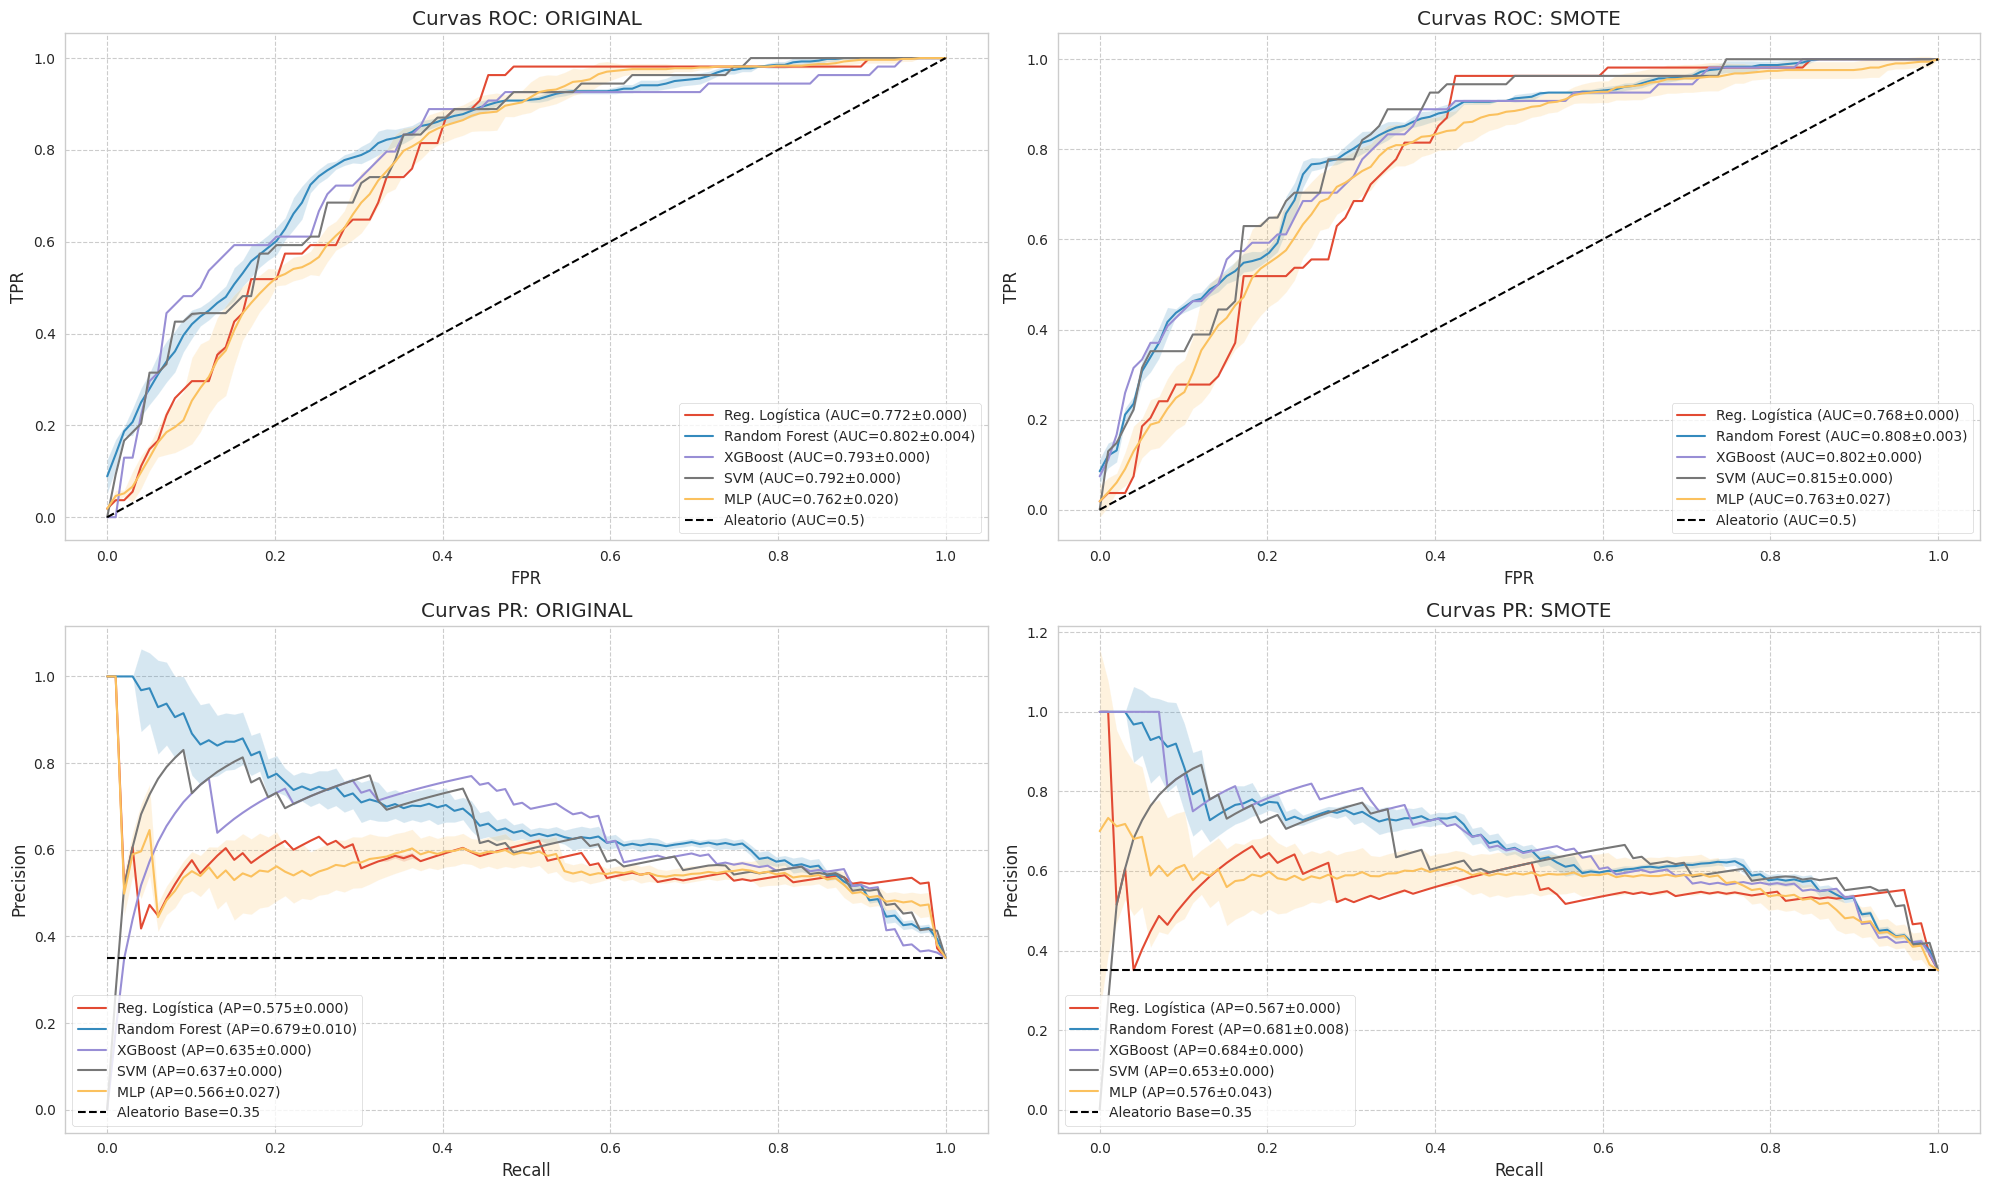

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] TABLA RESUMEN MÉTRICAS CV + TEST [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
df_resultados_final = pd.DataFrame(resultados_finales_df)

for estrategia in estrategias:
    print(Panel(f"[bold {COLOR_PANEL}] Métricas desglosadas {estrategia} [/bold {COLOR_PANEL}]"))

    df_estrategia = df_resultados_final[df_resultados_final["Estrategia"]==estrategia].reset_index(drop=True)

    # Tabla de métricas CV
    df_cv = df_estrategia[["Modelo", "Precision_CV","Recall_CV","F2_CV","AUC_CV"]]
    print("Métricas CV (media ± std):")
    display(df_cv.style.hide(axis="index")
                     .highlight_max(axis=0, color=COLOR_MAXIMOS, subset=["Recall_CV","F2_CV","AUC_CV"])
                     .format(precision=3))
    print("\n")

    # Tabla de métricas Test
    df_test = df_estrategia[["Modelo", "Precision_Test","Recall_Test","F2_Test","AUC_Test"]]
    print("Métricas Test (media ± std sobre 10 iteraciones):")
    display(df_test.style.hide(axis="index")
                      .highlight_max(axis=0, color="#e2f0d9", subset=["Recall_Test","F2_Test","AUC_Test"])
                      .format(precision=3))
    print("\n")


print(Panel(f"[bold {COLOR_PANEL}] Métricas CV + Test: ORIGINAL + SMOTE[/bold {COLOR_PANEL}]"))
#Quitamos columnas accuracy y precison para salida más legible
df_resultados_final = df_resultados_final.drop(columns=["Accuracy_CV","Accuracy_Test"])
display(df_resultados_final.style.hide(axis="index").highlight_max(axis=0, color=COLOR_MAXIMOS, subset=[
    "Recall_CV","F2_CV","AUC_CV","Recall_Test","F2_Test","AUC_Test"
]).format(precision=3))
print("\n")
# Guardamos los resultados en un archivo .csv
pd.DataFrame(resultados_finales_df).to_csv("Resultados_Detallados_TFM_sin_outliers.csv", index=False)


console.rule(f"[bold {COLOR_CEMP}] GRÁFICOS AUC y PR [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# Graficamos AUC-ROC
for i, estrategia in enumerate(estrategias):
    ax = axes[0, i]  # fila 0 para ROC
    ax.set_title(f"Curvas ROC: {estrategia}")
    for nombre, data in curvas_roc_pr[estrategia].items():
        mean_fpr = data["mean_fpr"]
        mean_tpr = data["mean_tpr"]
        std_tpr  = data["std_tpr"]
        mean_auc = data["mean_auc"]
        std_auc  = data["std_auc"]

        ax.plot(mean_fpr, mean_tpr, label=f"{nombre} (AUC={mean_auc:.3f}±{std_auc:.3f})")
        ax.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
    ax.plot([0,1], [0,1], "k--", label="Aleatorio (AUC=0.5)")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.grid(True, linestyle="--")
    ax.legend(loc="lower right")

# Graficamos curva PR
for i, estrategia in enumerate(estrategias):
    ax = axes[1, i]  # fila 1 para PR
    ax.set_title(f"Curvas PR: {estrategia}")
    for nombre, data in curvas_roc_pr[estrategia].items():
        mean_recall = data["mean_recall"]
        mean_precision = data["mean_precision"]
        std_precision  = data["std_precision"]
        mean_ap = data["mean_ap"]
        std_ap  = data["std_ap"]

        ax.plot(mean_recall, mean_precision, label=f"{nombre} (AP={mean_ap:.3f}±{std_ap:.3f})")
        ax.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)

    no_skill = y_test.mean()
    ax.plot([0,1], [no_skill,no_skill], "k--", label=f"Aleatorio Base={no_skill:.2f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True, linestyle="--")
    ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

##### => En conjunto CON outliers

In [ ]:
# Definimos las variables necesarias
estrategias = ["ORIGINAL", "SMOTE"]
resultados_finales_df_2 = []
curvas_roc_pr = {}
best_estimators_storage = {}

for estrategia in estrategias:
    console.rule(f"[bold {COLOR_CEMP}] BALANCEO: {estrategia} [/bold {COLOR_CEMP}]", style= COLOR_TITULOS)
    curvas_roc_pr[estrategia] = {}
    best_estimators_storage[estrategia] = {}

    for nombre_modelo, modelo_base in modelos.items():
        print(Panel(f"[bold {COLOR_PANEL}] {nombre_modelo} [/bold {COLOR_PANEL}]"))
        # Definimos pipeline
        pipeline = definir_pipeline(modelo_base=modelo_base, estrategia_balanceo=estrategia if estrategia!="ORIGINAL" else None)
        param_grid = param_grids[nombre_modelo]

        # Optimizamos el modelo con GridSearchCV
        grid_search = optimizar_modelo(pipeline, X_train_val_sin_NA, y_train_val , param_grid)
        best_estimator = grid_search.best_estimator_
        best_estimators_storage[estrategia][nombre_modelo] = best_estimator
        k_selected = grid_search.best_params_["selector__k"]

        #Imprimimos algo de información sobre el modelo seleccionado
        best_idx = grid_search.best_index_
        f2_mean = grid_search.cv_results_["mean_test_score"][best_idx]
        f2_std  = grid_search.cv_results_["std_test_score"][best_idx]
        print(f"- Mejor configuración de hiperparámetros: {grid_search.best_params_}")
        print(f"- F2-Score obtenido (media y std): {f2_mean:.4f} ± {f2_std:.4f}")
        selector = best_estimator.named_steps["selector"]
        selected_features = X_train_val_sin_NA.columns[selector.get_support()]
        print(f"- Features seleccionadas: {list(selected_features)}")

        # Obtenemos las métricas de CV con los mejores parámetros elegidos
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        accs = cross_val_score(best_estimator, X_train_val_sin_NA, y_train_val, cv=cv_strategy, scoring="accuracy", n_jobs=-1)
        precs = cross_val_score(best_estimator, X_train_val_sin_NA, y_train_val, cv=cv_strategy, scoring="precision", n_jobs=-1)
        recs = cross_val_score(best_estimator, X_train_val_sin_NA, y_train_val, cv=cv_strategy, scoring="recall", n_jobs=-1)
        f2s  = cross_val_score(best_estimator, X_train_val_sin_NA, y_train_val, cv=cv_strategy, scoring=make_scorer(fbeta_score, beta=2), n_jobs=-1)
        aucs = cross_val_score(best_estimator, X_train_val_sin_NA, y_train_val, cv=cv_strategy, scoring="roc_auc", n_jobs=-1)

        # Evaluamos el modelo escogido en el conjunto de TEST entrenando 10 veces
        df_test_runs, curvas_media = evaluar_modelo_iterativo(best_estimator, X_train_val_sin_NA, y_train_val, X_test_sin_NA, y_test, n_reps=10)

        # Guardamos los resultados
        resultados_finales_df_2.append({
          "Estrategia": estrategia,
          "Modelo": nombre_modelo,
          "K_Features": k_selected,
          "Mejores_Params": grid_search.best_params_,
          "Accuracy_CV": f"{np.mean(accs):.3f} ± {np.std(accs):.3f}",
          "Precision_CV": f"{np.mean(precs):.3f} ± {np.std(precs):.3f}",
          "Recall_CV": f"{np.mean(recs):.3f} ± {np.std(recs):.3f}",
          "F2_CV": f"{np.mean(f2s):.3f} ± {np.std(f2s):.3f}",
          "AUC_CV": f"{np.mean(aucs):.3f} ± {np.std(aucs):.3f}",
          "Accuracy_Test": f"{df_test_runs['Accuracy'].mean():.3f} ± {df_test_runs['Accuracy'].std():.3f}",
          "Precision_Test": f"{df_test_runs['Precision'].mean():.3f} ± {df_test_runs['Precision'].std():.3f}",
          "Recall_Test": f"{df_test_runs['Recall'].mean():.3f} ± {df_test_runs['Recall'].std():.3f}",
          "F2_Test": f"{df_test_runs['F2'].mean():.3f} ± {df_test_runs['F2'].std():.3f}",
          "AUC_Test": f"{df_test_runs['AUC'].mean():.3f} ± {df_test_runs['AUC'].std():.3f}"

      })

        # Guardamos curvas ROC/PR medias ± std
        curvas_roc_pr[estrategia][nombre_modelo] = curvas_media

──────────────────────────────────────────────  BALANCEO: ORIGINAL  ───────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Reg. Logística                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 100, 'model__class_weight': 'balanced', 'model__penalty': 
'l1', 'selector__k': 10}

- F2-Score obtenido (media y std): 0.7198 ± 0.0202

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Random Forest                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__class_weight': 'balanced', 'model__max_depth': 5, 
'model__min_samples_split': 2, 'model__n_estimators': 200, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.7461 ± 0.0259

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  XGBoost                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 
'model__n_estimators': 100, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.6408 ± 0.0210

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  SVM                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 
'scale', 'model__kernel': 'rbf', 'selector__k': 7}

- F2-Score obtenido (media y std): 0.7371 ± 0.0230

- Features seleccionadas: ['Glucose', 'Insulin', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  MLP                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__activation': 'relu', 'model__alpha': 0.0001, 
'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.001, 'selector__k': 10}

- F2-Score obtenido (media y std): 0.6508 ± 0.0160

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

────────────────────────────────────────────────  BALANCEO: SMOTE  ────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Reg. Logística                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 100, 'model__class_weight': None, 'model__penalty': 'l1', 
'selector__k': 7}

- F2-Score obtenido (media y std): 0.7141 ± 0.0280

- Features seleccionadas: ['Glucose', 'Insulin', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Random Forest                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__class_weight': None, 'model__max_depth': 5, 
'model__min_samples_split': 2, 'model__n_estimators': 100, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.7670 ± 0.0194

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  XGBoost                                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__learning_rate': 0.05, 'model__max_depth': 3, 
'model__n_estimators': 50, 'selector__k': 'all'}

- F2-Score obtenido (media y std): 0.7357 ± 0.0296

- Features seleccionadas: ['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DPF', 'Age', 
'Indice_resistencia', 'BMI_square', 'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  SVM                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__C': 0.1, 'model__class_weight': None, 'model__gamma': 'scale', 
'model__kernel': 'rbf', 'selector__k': 7}

- F2-Score obtenido (media y std): 0.7471 ± 0.0158

- Features seleccionadas: ['Glucose', 'Insulin', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  MLP                                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

- Mejor configuración de hiperparámetros: {'model__activation': 'relu', 'model__alpha': 0.0001, 
'model__hidden_layer_sizes': (10,), 'model__learning_rate_init': 0.01, 'selector__k': 7}

- F2-Score obtenido (media y std): 0.7251 ± 0.0431

- Features seleccionadas: ['Glucose', 'Insulin', 'BMI', 'Age', 'Indice_resistencia', 'BMI_square', 
'Is_prediabetes']

───────────────────────────────────────  TABLA RESUMEN MÉTRICAS CV + TEST  ────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas desglosadas ORIGINAL                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Métricas CV (media ± std):

Métricas Test (media ± std sobre 10 iteraciones):

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas desglosadas SMOTE                                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Métricas CV (media ± std):

Métricas Test (media ± std sobre 10 iteraciones):

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Métricas CV + Test: ORIGINAL + SMOTE                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────  GRÁFICOS AUC y PR  ───────────────────────────────────────────────

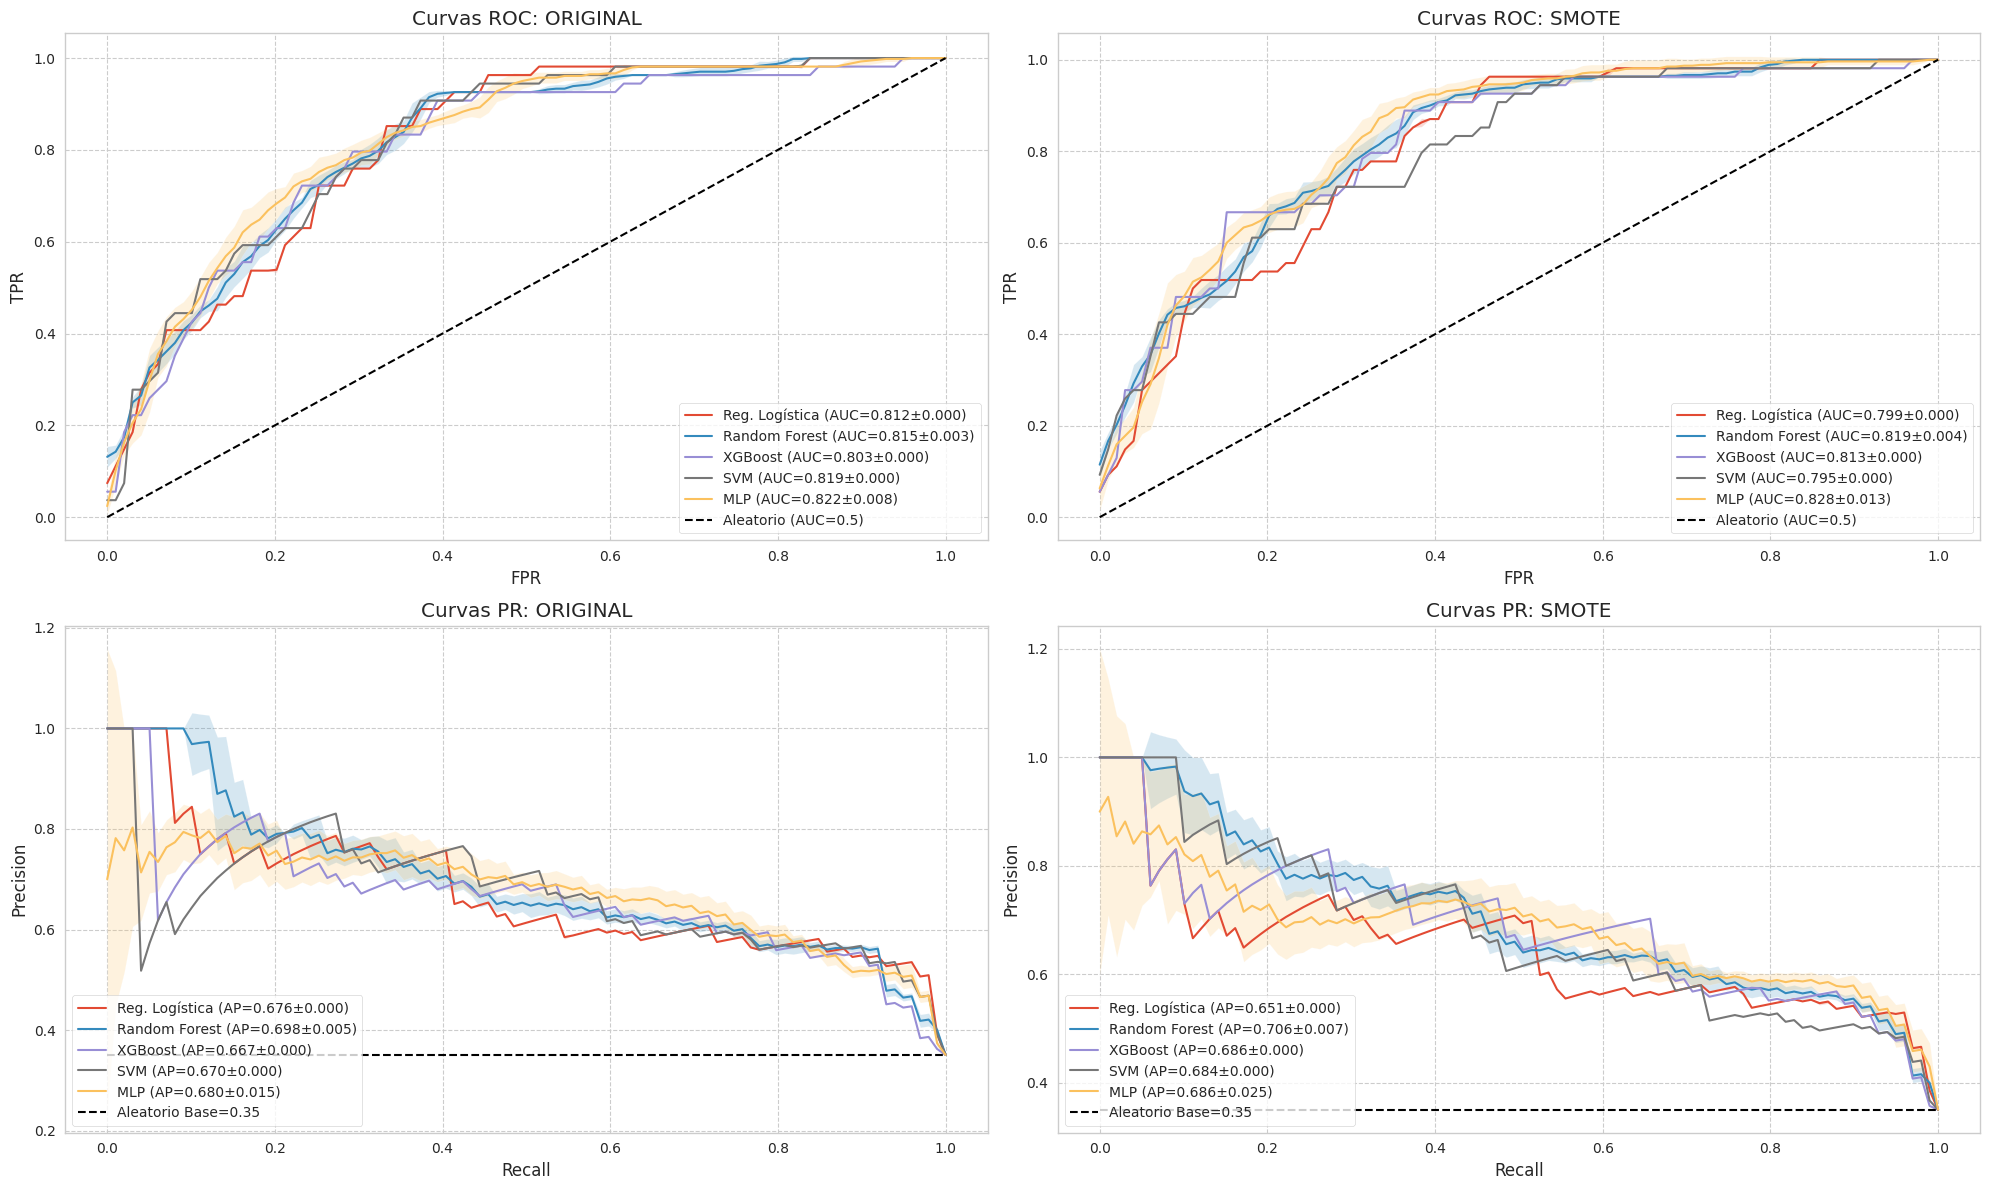

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] TABLA RESUMEN MÉTRICAS CV + TEST [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
df_resultados_final_out = pd.DataFrame(resultados_finales_df_2)

for estrategia in estrategias:
    print(Panel(f"[bold {COLOR_PANEL}] Métricas desglosadas {estrategia} [/bold {COLOR_PANEL}]"))

    df_estrategia_out = df_resultados_final_out[df_resultados_final_out["Estrategia"]==estrategia].reset_index(drop=True)

    # Tabla de métricas CV
    df_cv = df_estrategia_out[["Modelo", "Precision_CV","Recall_CV","F2_CV","AUC_CV"]]
    print("Métricas CV (media ± std):")
    display(df_cv.style.hide(axis="index")
                     .highlight_max(axis=0, color=COLOR_MAXIMOS, subset=["Recall_CV","F2_CV","AUC_CV"])
                     .format(precision=3))
    print("\n")

    # Tabla de métricas Test
    df_test = df_estrategia_out[["Modelo", "Precision_Test","Recall_Test","F2_Test","AUC_Test"]]
    print("Métricas Test (media ± std sobre 10 iteraciones):")
    display(df_test.style.hide(axis="index")
                      .highlight_max(axis=0, color="#e2f0d9", subset=["Recall_Test","F2_Test","AUC_Test"])
                      .format(precision=3))
    print("\n")


print(Panel(f"[bold {COLOR_PANEL}] Métricas CV + Test: ORIGINAL + SMOTE [/bold {COLOR_PANEL}]"))
#Quitamos columnas accuracy y precison para salida más legible
df_resultados_final_out = df_resultados_final_out.drop(columns=["Accuracy_CV","Accuracy_Test"])
display(df_resultados_final_out.style.hide(axis="index").highlight_max(axis=0, color=COLOR_MAXIMOS, subset=[
    "Recall_CV","F2_CV","AUC_CV","Recall_Test","F2_Test","AUC_Test"
]).format(precision=3))
print("\n")
# Guardamos los resultados en un archivo .csv
pd.DataFrame(resultados_finales_df_2).to_csv("Resultados_Detallados_TFM_con_outliers.csv", index=False)


console.rule(f"[bold {COLOR_CEMP}] GRÁFICOS AUC y PR [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
# Graficamos AUC-ROC
for i, estrategia in enumerate(estrategias):
    ax = axes[0, i]  # fila 0 para ROC
    ax.set_title(f"Curvas ROC: {estrategia}")
    for nombre, data in curvas_roc_pr[estrategia].items():
        mean_fpr = data["mean_fpr"]
        mean_tpr = data["mean_tpr"]
        std_tpr  = data["std_tpr"]
        mean_auc = data["mean_auc"]
        std_auc  = data["std_auc"]

        ax.plot(mean_fpr, mean_tpr, label=f"{nombre} (AUC={mean_auc:.3f}±{std_auc:.3f})")
        ax.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, alpha=0.2)
    ax.plot([0,1], [0,1], "k--", label="Aleatorio (AUC=0.5)")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.grid(True, linestyle="--")
    ax.legend(loc="lower right")

# Graficamos curva PR
for i, estrategia in enumerate(estrategias):
    ax = axes[1, i]  # fila 1 para PR
    ax.set_title(f"Curvas PR: {estrategia}")
    for nombre, data in curvas_roc_pr[estrategia].items():
        mean_recall = data["mean_recall"]
        mean_precision = data["mean_precision"]
        std_precision  = data["std_precision"]
        mean_ap = data["mean_ap"]
        std_ap  = data["std_ap"]

        ax.plot(mean_recall, mean_precision, label=f"{nombre} (AP={mean_ap:.3f}±{std_ap:.3f})")
        ax.fill_between(mean_recall, mean_precision - std_precision, mean_precision + std_precision, alpha=0.2)

    no_skill = y_test.mean()
    ax.plot([0,1], [no_skill,no_skill], "k--", label=f"Aleatorio Base={no_skill:.2f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.grid(True, linestyle="--")
    ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] RESUMEN ESTRATEGIAS [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}] 1) Métricas CV: SIN OUTLIERS [/bold {COLOR_PANEL}]"))
resumen_cv = df_resultados_final.groupby("Estrategia").agg({
    "Precision_CV": lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Recall_CV":    lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "F2_CV":        lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "AUC_CV":       lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Precision_Test": lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Recall_Test":    lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "F2_Test":        lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "AUC_Test":       lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}"

})

display(resumen_cv.style.highlight_max(axis=0, color=COLOR_MAXIMOS).format(precision=3))

print(Panel(f"[bold {COLOR_PANEL}] 2) Métricas CV: CON OUTLIERS [/bold {COLOR_PANEL}]"))
resumen_cv_out = df_resultados_final_out.groupby("Estrategia").agg({
    "Precision_CV": lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Recall_CV":    lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "F2_CV":        lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "AUC_CV":       lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Precision_Test": lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "Recall_Test":    lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "F2_Test":        lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}",
    "AUC_Test":       lambda x: f"{np.mean([float(v.split(' ± ')[0]) for v in x]):.3f} ± {np.mean([float(v.split(' ± ')[1]) for v in x]):.3f}"
})

display(resumen_cv_out.style.highlight_max(axis=0, color=COLOR_MAXIMOS).format(precision=3))

──────────────────────────────────────────────  RESUMEN ESTRATEGIAS  ──────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Métricas CV: SIN OUTLIERS                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  2) Métricas CV: CON OUTLIERS                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Aunque eliminar outliers produzca métricas más altas, mantenerlos permite que los modelos sean más robustos y aplicables en la práctica clínica, detectando correctamente pacientes con valores fuera de lo normal. En pocas palabras, es mejor un modelo que funcione bien con todos los pacientes, incluso los extremos, que uno que solo funcione con los pacientes “normales”.

- Nos quedamos dado los mejores resultados obtenidos con **CON OUTLIERS**.

### **5.- Modelo seleccionado**

Dada las métricas y la interpretabilidad que aporta, seleccionaremos Random Forest de la Estrategia ORIGINAL manteniendo los outliers.

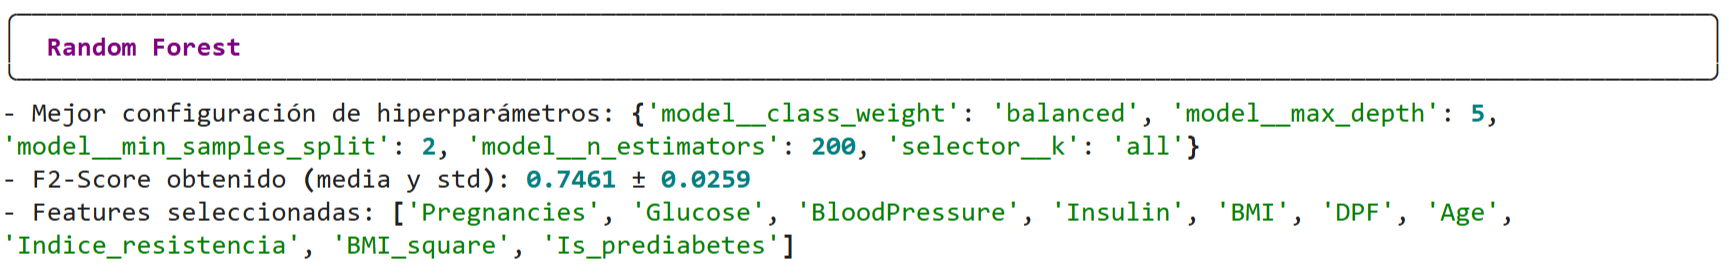

In [ ]:
# Seleccionamos el mejor tras observar detenidamente
filtro = df_final[["Estrategia", "Modelo"]].apply(tuple, axis=1).isin([("ORIGINAL", "Random Forest")])
df_final[filtro]

Estrategia         Modelo K_Features  \
1   ORIGINAL  Random Forest        all   

                                      Mejores_Params   Precision_CV  \
1  {'model__class_weight': 'balanced', 'model__ma...  0.664 ± 0.020   

       Recall_CV          F2_CV         AUC_CV Precision_Test    Recall_Test  \
1  0.771 ± 0.036  0.746 ± 0.026  0.842 ± 0.018  0.604 ± 0.010  0.733 ± 0.018   

         F2_Test       AUC_Test  
1  0.703 ± 0.015  0.815 ± 0.003

In [ ]:
# ENTRENAMOS Y VALIDAMOS EL MODELO SELECCIONADO
rf_pipeline = ImbPipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k="all")),
    ("model", RandomForestClassifier(class_weight="balanced", max_depth=5, min_samples_split=2, n_estimators=200, random_state = 7))
])

#### **5.1.- Evaluación de métricas**

In [ ]:
rf_metrics = clone(rf_pipeline)
rf_metrics.fit(X_train_val_sin_NA, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', SelectKBest(k='all')),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=7))])

────────────────────────────  MATRICES DE CONFUSIÓN MODELO SELECCIONADO: RF ORIGINAL  ─────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   1) Entrenamiento                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

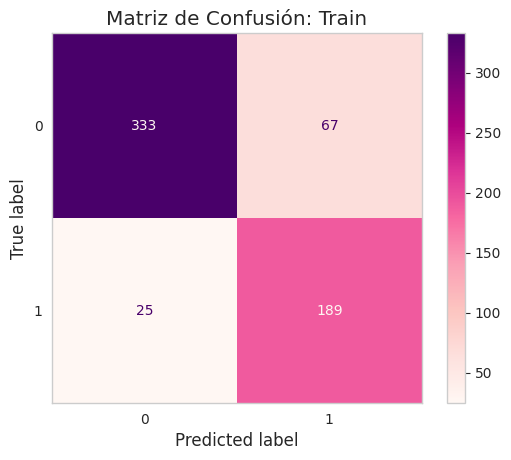

Métricas train:
Accuracy: 0.850 | Precision: 0.738 | Recall: 0.883 | F2-score: 0.850

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   2) Test                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

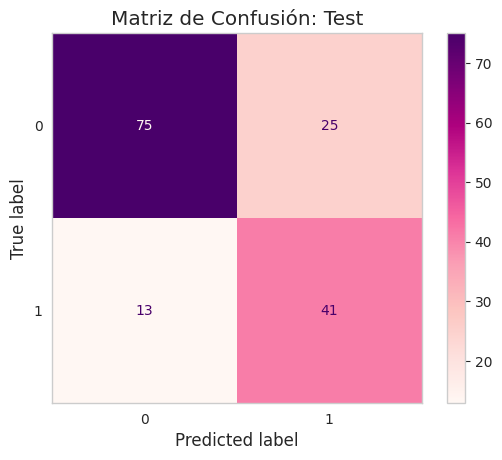

Métricas Test:
Accuracy: 0.753 | Precision: 0.621 | Recall: 0.759 | F2-score: 0.727

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] MATRICES DE CONFUSIÓN MODELO SELECCIONADO: RF ORIGINAL [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)

print(Panel(f"[bold {COLOR_PANEL}]  1) Entrenamiento [/bold {COLOR_PANEL}]"))
# Matriz de confusión
y_train_pred = rf_metrics.predict(X_train_val_sin_NA)
matriz_train = confusion_matrix(y_train_val, y_train_pred)
disp_train = ConfusionMatrixDisplay(matriz_train)
disp_train.plot(cmap="RdPu")
plt.title("Matriz de Confusión: Train")
plt.grid(False)
plt.show()

# Métricas
accuracy_train = accuracy_score(y_train_val, y_train_pred)
precision_train = precision_score(y_train_val, y_train_pred, zero_division=0)
recall_train = recall_score(y_train_val, y_train_pred, zero_division=0)
f2_train = fbeta_score(y_train_val, y_train_pred, beta=2, zero_division=0)
print(f"Métricas train:\nAccuracy: {accuracy_train:.3f} | Precision: {precision_train:.3f} | Recall: {recall_train:.3f} | F2-score: {f2_train:.3f}\n")


print(Panel(f"[bold {COLOR_PANEL}]  2) Test [/bold {COLOR_PANEL}]"))
# Matriz confusión
y_test_pred = rf_metrics.predict(X_test_sin_NA)
matriz_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(matriz_test)
disp_test.plot(cmap="RdPu")
plt.title("Matriz de Confusión: Test")
plt.grid(False)
plt.show()

# Métricas
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, zero_division=0)
recall_test = recall_score(y_test, y_test_pred, zero_division=0)
f2_test = fbeta_score(y_test, y_test_pred, beta=2, zero_division=0)
print(f"Métricas Test:\nAccuracy: {accuracy_test:.3f} | Precision: {precision_test:.3f} | Recall: {recall_test:.3f} | F2-score: {f2_test:.3f}\n")


#### **5.2.- Modificación del threshold**

A continuación, se realizará una modificación del umbral de decisión del modelo para maximizar el F2-score, priorizando la sensibilidad (recall) en la detección de pacientes positivos.
 En lugar de .predict(), usamos .predict_proba() para ver la "seguridad" del modelo
- Nos quedamos con la columna [:, 1] que es la probabilidad de clase positiva (Diabetes)

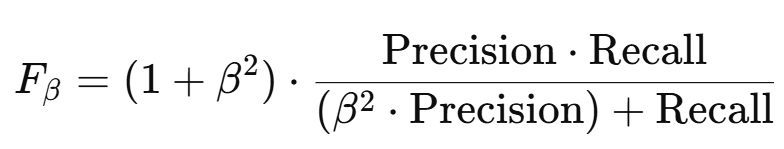

───────────────────────────────────  AJUSTE DEL UMBRAL DE DECISIÓN (F2-Óptimo)  ───────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  1) Resultados                                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

UMBRAL ÓPTIMO ENCONTRADO: 0.2712

- F2-Score máximo en ese umbral: 0.8197

- Recall esperado: 0.9259 // Precision esperada: 0.5618)

UMBRAL POR DEFECTO O.5:

- Recall: 0.7593 // Precision: 0.6212

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  2) Curva Precision-Recall con umbral óptimo                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

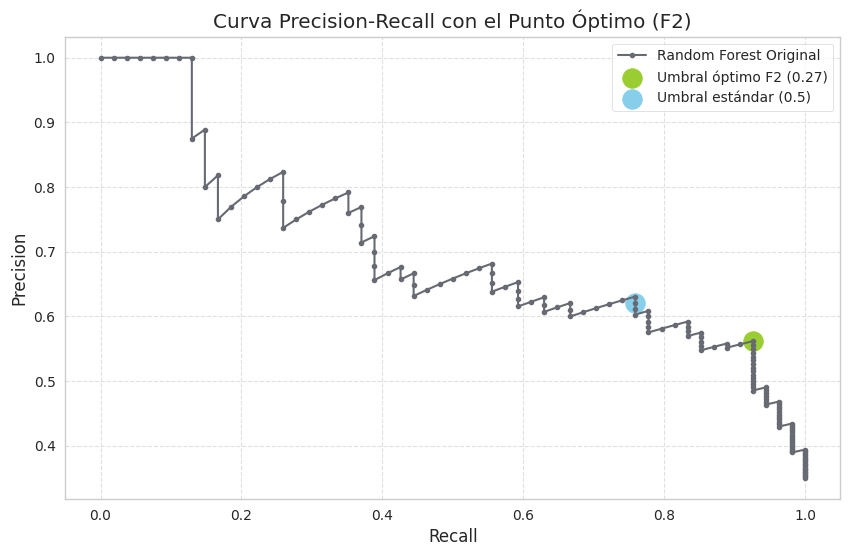

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  3) Distribución de probabilidades por 'Outcome'                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

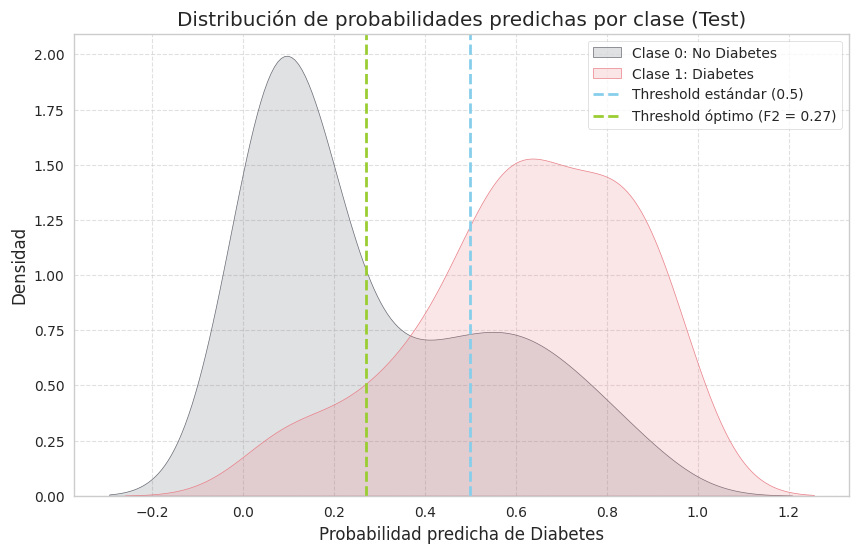

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] AJUSTE DEL UMBRAL DE DECISIÓN (F2-Óptimo) [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
# 1) Calculamos la curva precision-recall
y_probs = rf_metrics.predict_proba(X_test_sin_NA)[:, 1]
probs_no_diabetes = y_probs[y_test == 0]
probs_diabetes = y_probs[y_test == 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 2) Calculamos el F2-Score para cada umbral posible
numerador = (1 + 2**2) * precision * recall
denominador = (2**2 * precision) + recall
f2_scores = np.divide(numerador, denominador, out=np.zeros_like(denominador), where=denominador!=0)

# 3) Buscamos el índice donde el F2 es máximo
ix_best = np.argmax(f2_scores)
best_thresh = thresholds[ix_best]
best_f2 = f2_scores[ix_best]

# 4) Buscamos el índice correspondiente al umbral por defecto (0.5)
thresh_estandar = 0.5
ix_05 = np.argmin(np.abs(thresholds - thresh_estandar))
precision_05 = precision[ix_05]
recall_05 = recall[ix_05]

print(Panel(f"[bold {COLOR_PANEL}] 1) Resultados [/bold {COLOR_PANEL}]"))
print(f"UMBRAL ÓPTIMO ENCONTRADO: {best_thresh:.4f}")
print(f"- F2-Score máximo en ese umbral: {best_f2:.4f}")
print(f"- Recall esperado: {recall[ix_best]:.4f} // Precision esperada: {precision[ix_best]:.4f})")
print("\n")
print("UMBRAL POR DEFECTO O.5:")
print(f"- Recall: {recall_05:.4f} // Precision: {precision_05:.4f} ")

print(Panel(f"[bold {COLOR_PANEL}] 2) Curva Precision-Recall con umbral óptimo [/bold {COLOR_PANEL}]"))
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker=".", label="Random Forest Original", color = COLOR_TITULOS)
plt.scatter(recall[ix_best], precision[ix_best], marker="o", color= "yellowgreen", s=200, label=f"Umbral óptimo F2 ({best_thresh:.2f})")
plt.scatter(recall_05, precision_05, marker="o", color= "skyblue", s=200, label="Umbral estándar (0.5)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con el Punto Óptimo (F2)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

print(Panel(f"[bold {COLOR_PANEL}] 3) Distribución de probabilidades por 'Outcome'[/bold {COLOR_PANEL}]"))

plt.figure(figsize=(10, 6))
sns.kdeplot(probs_no_diabetes, fill=True, alpha=0.2, label="Clase 0: No Diabetes", color=COLOR_TITULOS)
sns.kdeplot(probs_diabetes, fill=True, alpha=0.2, label="Clase 1: Diabetes", color= COLOR_CEMP)

# Líneas para threshold estándar + óptimo
plt.axvline(0.5, color="skyblue", linestyle="--", linewidth=2, label="Threshold estándar (0.5)")
plt.axvline(best_thresh, color= "yellowgreen", linestyle="--", linewidth=2, label=f"Threshold óptimo (F2 = {best_thresh:.2f})")

plt.xlabel("Probabilidad predicha de Diabetes")
plt.ylabel("Densidad")
plt.title("Distribución de probabilidades predichas por clase (Test)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


- **Recall** = 0.926 → casi ningún paciente enfermo se queda sin detectar.

- **Precision** = 0.562 → algunos pacientes se etiquetan como positivos sin serlo, pero eso se corrige con pruebas confirmatorias posteriores.

Lo importante es que el modelo minimiza los falsos negativos, que es lo que más riesgo conlleva clínicamente.

───────────────────────  DIFERENCIAS: THRESHOLD ESTÁNDAR (0.5) vs THRESHOLD ÓPTIMO (0.27)  ────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   1) Tabla comparativa métricas TRAIN                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Threshold 0.5  Threshold Óptimo  Diferencia Train
Accuracy            0.85              0.75             -0.10
Precision           0.74              0.58             -0.16
Recall              0.88              0.99              0.10
F2                  0.85              0.87              0.02
AUC                 0.94              0.94              0.00

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   2) Matriz de confusión TEST                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

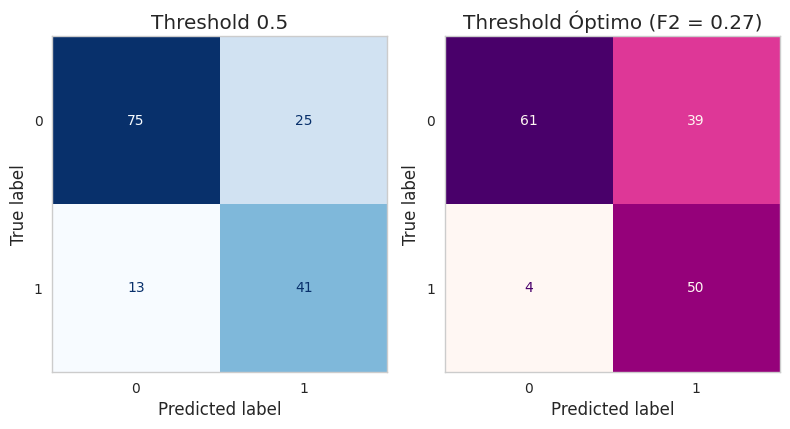

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   3) Tabla comparativa métricas TEST                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Threshold 0.5  Threshold Óptimo  Diferencia Test
Accuracy            0.75              0.72            -0.03
Precision           0.62              0.56            -0.06
Recall              0.76              0.93             0.17
F2                  0.73              0.82             0.09
AUC                 0.82              0.82             0.00

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] DIFERENCIAS: THRESHOLD ESTÁNDAR (0.5) vs THRESHOLD ÓPTIMO (0.27) [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
# Calculamos las probabilidades y predicciones con distintos umbrales - TRAIN
y_train_probs = rf_metrics.predict_proba(X_train_val_sin_NA)[:, 1]
y_train_pred_05 = (y_train_probs >= 0.5).astype(int)
y_train_pred_opt = (y_train_probs >= best_thresh).astype(int)

# Calculamos las probabilidades y predicciones con distintos umbrales - TEST
y_test_probs  = rf_metrics.predict_proba(X_test_sin_NA)[:, 1]
# Predicciones
y_test_pred_05   = (y_test_probs >= 0.5).astype(int)
y_test_pred_opt  = (y_test_probs >= best_thresh).astype(int)

#Métricas TRAIN
metrics_train_05 = calcular_metricas(y_train_val, y_train_pred_05, y_train_probs)
metrics_train_opt = calcular_metricas(y_train_val, y_train_pred_opt, y_train_probs)
df_diferencia_train = pd.DataFrame({"Threshold 0.5": metrics_train_05, "Threshold Óptimo": metrics_train_opt,
                              "Diferencia Train": {k: metrics_train_opt[k]-metrics_train_05[k] for k in metrics_train_05},}).round(2)

#Métricas TEST
metrics_test_05 = calcular_metricas(y_test, y_test_pred_05, y_test_probs)
metrics_test_opt = calcular_metricas(y_test, y_test_pred_opt, y_test_probs)
df_diferencia_test = pd.DataFrame({"Threshold 0.5": metrics_test_05, "Threshold Óptimo": metrics_test_opt,
                              "Diferencia Test": {k: metrics_test_opt[k]-metrics_test_05[k] for k in metrics_test_05},}).round(2)


print(Panel(f"[bold {COLOR_PANEL}]  1) Tabla comparativa métricas TRAIN [/bold {COLOR_PANEL}]"))
display(df_diferencia_train)

print(Panel(f"[bold {COLOR_PANEL}]  2) Matriz de confusión TEST [/bold {COLOR_PANEL}]"))
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
# Umbral 0.5
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_05)).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Threshold 0.5")
axes[0].grid(False)

# Umbral 0.27
ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred_opt)).plot(ax=axes[1], cmap="RdPu", colorbar=False)
axes[1].set_title(f"Threshold Óptimo (F2 = {best_thresh:.2f})")
axes[1].grid(False)
plt.tight_layout()
plt.show()

print(Panel(f"[bold {COLOR_PANEL}]  3) Tabla comparativa métricas TEST [/bold {COLOR_PANEL}]"))
display(df_diferencia_test)

Aunque el modelo estándar detectaba al 74% de los pacientes, optimizamos el criterio clínico para detectar a más del 90%, aceptando un ligero aumento en las falsas alarmas por seguridad del paciente. No utilizamos el umbral estándar de 0.5 porque en el diagnóstico de diabetes es crítico priorizar la sensibilidad. Realizamos un barrido de umbrales optimizando la métrica F2-Score, la cual pondera el Recall por encima de la Precisión. El análisis matemático determinó que el umbral óptimo es 0.27, punto donde maximizamos la detección de enfermos sin degradar excesivamente la precisión del diagnóstico.

**VERIFICACIÓN THRESHOLD**

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EVALUACIÓN TEST MODELO ITERATIVO: 10 REPETICIONES [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}]  1) THRESHOLD ESTÁNDAR [/bold {COLOR_PANEL}]"))
df_test_05, curvas_05 = evaluar_modelo_iterativo(rf_metrics, X_train_val_sin_NA, y_train_val, X_test_sin_NA, y_test, n_reps=10)
metrics_mean_05 = df_test_05.mean().round(3)
metrics_std_05  = df_test_05.std().round(3)
display(pd.DataFrame({"Media": metrics_mean_05, "Std": metrics_std_05}).T)

print(Panel(f"[bold {COLOR_PANEL}]  2) THRESHOLD ÓPTIMO [/bold {COLOR_PANEL}]"))
df_test_opt, curvas_opt = evaluar_modelo_iterativo(rf_metrics, X_train_val_sin_NA, y_train_val, X_test_sin_NA, y_test, n_reps=10, threshold=best_thresh)
metrics_mean_opt = df_test_opt.mean().round(3)
metrics_std_opt = df_test_opt.std().round(3)
display(pd.DataFrame({"Media": metrics_mean_opt,"Std": metrics_std_opt}).T)

───────────────────────────────  EVALUACIÓN TEST MODELO ITERATIVO: 10 REPETICIONES  ───────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   1) THRESHOLD ESTÁNDAR                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Accuracy  Precision  Recall     F2    AUC
Media     0.738      0.604   0.733  0.703  0.815
Std       0.009      0.010   0.018  0.015  0.003

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   2) THRESHOLD ÓPTIMO                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Accuracy  Precision  Recall     F2    AUC
Media     0.718      0.560   0.922  0.816  0.815
Std       0.008      0.007   0.008  0.007  0.003

#### **5.3.- Explicabilidad**

In [ ]:
rf_explain = clone(rf_pipeline)
rf_explain.fit(X_train_val_sin_NA, y_train_val)

Pipeline(steps=[('scaler', StandardScaler()),
                ('selector', SelectKBest(k='all')),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=7))])

────────────────────────────────────────────────  EXPLICABILIDAD  ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Relevancia estadística de las variables (ANOVA F-score)                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

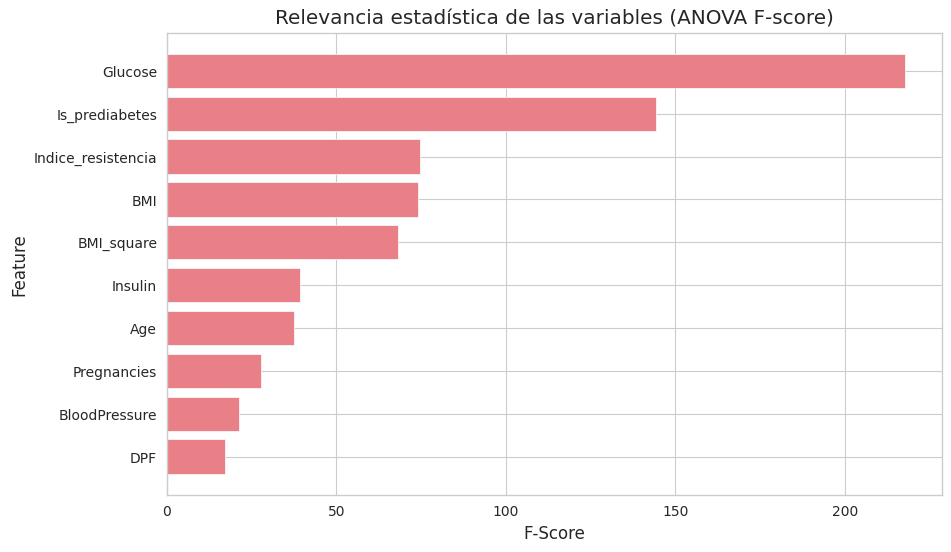

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EXPLICABILIDAD [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}] Relevancia estadística de las variables (ANOVA F-score)[/bold {COLOR_PANEL}]"))
selector = rf_explain.named_steps["selector"]
scores = selector.scores_
pvalues = selector.pvalues_

feature_scores = pd.DataFrame({"feature": X_train_val_sin_NA.columns, "f_score": scores, "p_value": pvalues}).sort_values(by="f_score", ascending=True)
# Gráfico barras
plt.figure(figsize=(10, 6))
plt.barh(feature_scores["feature"], feature_scores["f_score"], color=COLOR_CEMP)
plt.xlabel("F-Score")
plt.ylabel("Feature")
plt.title("Relevancia estadística de las variables (ANOVA F-score)")
plt.show()

────────────────────────────────────────────────  EXPLICABILIDAD  ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Importancia de variables según el modelo (Random Forest)                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

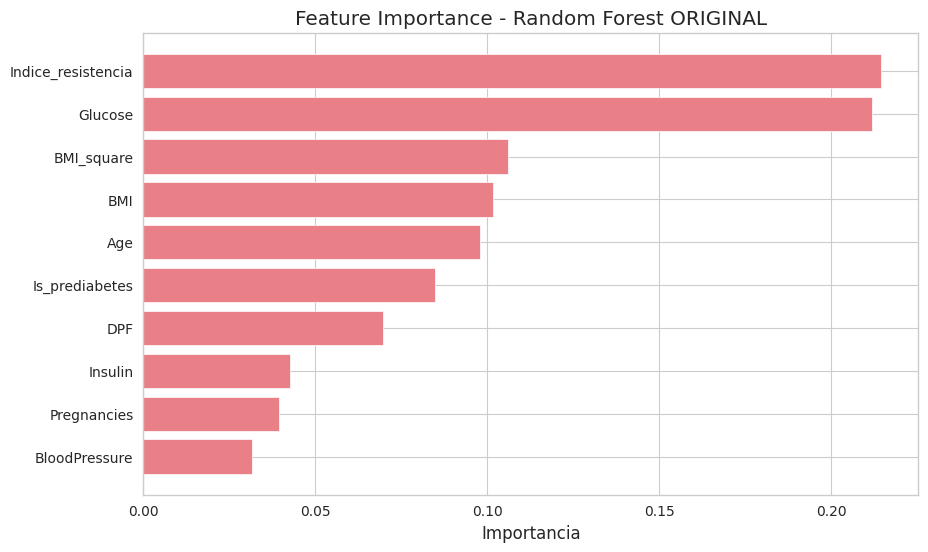

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EXPLICABILIDAD [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)

print(Panel(f"[bold {COLOR_PANEL}]  Importancia de variables según el modelo (Random Forest) [/bold {COLOR_PANEL}]"))
importancia = rf_explain.named_steps["model"].feature_importances_
features = X_train_val_sin_NA.columns
feat_imp_df = pd.DataFrame({"Feature": features, "Importancia": importancia})
feat_imp_df = feat_imp_df.sort_values(by="Importancia", ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importancia"], color=COLOR_CEMP)
plt.gca().invert_yaxis()
plt.xlabel("Importancia")
plt.title("Feature Importance - Random Forest ORIGINAL")
plt.show()

────────────────────────────────────────────────  EXPLICABILIDAD  ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   Permutation importance                                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Feature  Importancia_media  Importancia_std
7  Indice_resistencia           0.115741         0.035561
6                 Age           0.109259         0.027405
8          BMI_square           0.099074         0.027011
4                 BMI           0.088889         0.025256
1             Glucose           0.083333         0.035380
3             Insulin           0.024074         0.015604
0         Pregnancies           0.013889         0.012930
5                 DPF           0.012037         0.012108
2       BloodPressure           0.009259         0.012423
9      Is_prediabetes           0.000000         0.000000

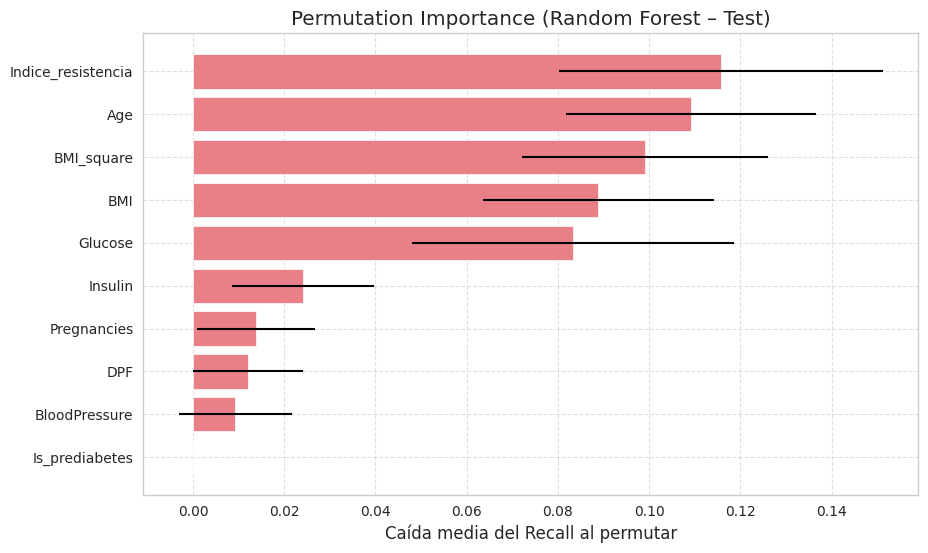

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EXPLICABILIDAD [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}]  Permutation importance [/bold {COLOR_PANEL}]"))

perm_importance = permutation_importance(rf_explain, X_test_sin_NA, y_test, n_repeats=20, scoring="recall", random_state=7, n_jobs=-1)

# 1) Mostramos el DF
perm_df = pd.DataFrame({
    "Feature": X_test_sin_NA.columns,
    "Importancia_media": perm_importance.importances_mean,
    "Importancia_std": perm_importance.importances_std
}).sort_values("Importancia_media", ascending=False)
display(perm_df)
print("\n")

# Graficamos
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
plt.barh(perm_df["Feature"], perm_df["Importancia_media"], xerr=perm_df["Importancia_std"], color=COLOR_CEMP)
plt.gca().invert_yaxis()
plt.xlabel("Caída media del Recall al permutar")
plt.title("Permutation Importance (Random Forest – Test)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

────────────────────────────────────────────────  EXPLICABILIDAD  ─────────────────────────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│  Shap Values                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Calculando valores SHAP con Explainer...

ExactExplainer explainer: 155it [01:24,  1.81it/s]


Generando Summary Plot...

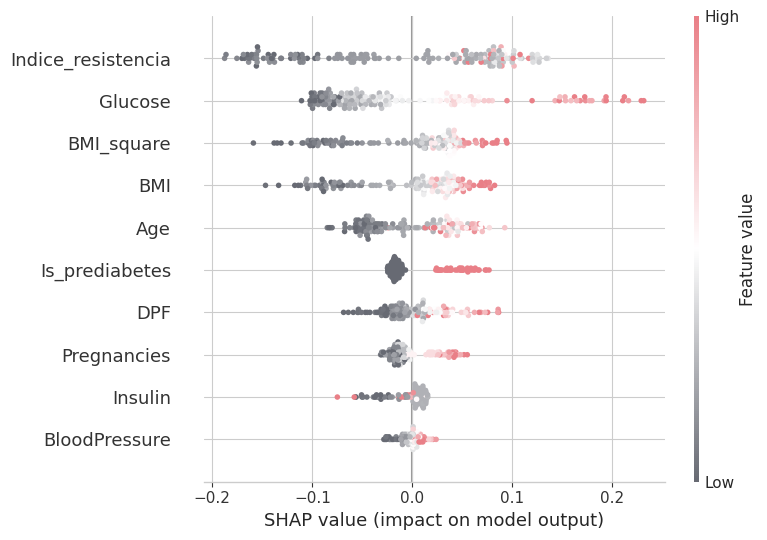

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EXPLICABILIDAD [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}] Shap Values [/bold {COLOR_PANEL}]"))

modelo_final = rf_explain.named_steps["model"]

#Aplicamos transformaciones al conjunto de TEST
preprocessor_pipeline = ImbPipeline([
    ("scaler", rf_explain.named_steps["scaler"]),
    ("selector", rf_explain.named_steps["selector"])])
X_selected_array = preprocessor_pipeline.transform(X_test_sin_NA)
feature_names = X_test_sin_NA.columns
X_selected_df = pd.DataFrame(X_selected_array, columns=feature_names)

# Definimos y calculamos los valores shap con Explainer
predict_proba_class_1 = lambda X: modelo_final.predict_proba(X)[:, 1]

print("Calculando valores SHAP con Explainer...")
explainer = shap.Explainer(predict_proba_class_1, X_selected_df, feature_names=feature_names)
shap_values = explainer(X_selected_df)

print("\nGenerando Summary Plot...")
shap.summary_plot(shap_values.values, X_selected_df, cmap = cmap_personalizado, show=True)

**SHAP VALUES PACIENTE INDIVIDUAL**

Analizamos, por ejemplo, el primer paciente [0] -> primera posición

───────────────────────────────────────  EXPLICABILIDAD PACIENTE CONCRETO  ────────────────────────────────────────

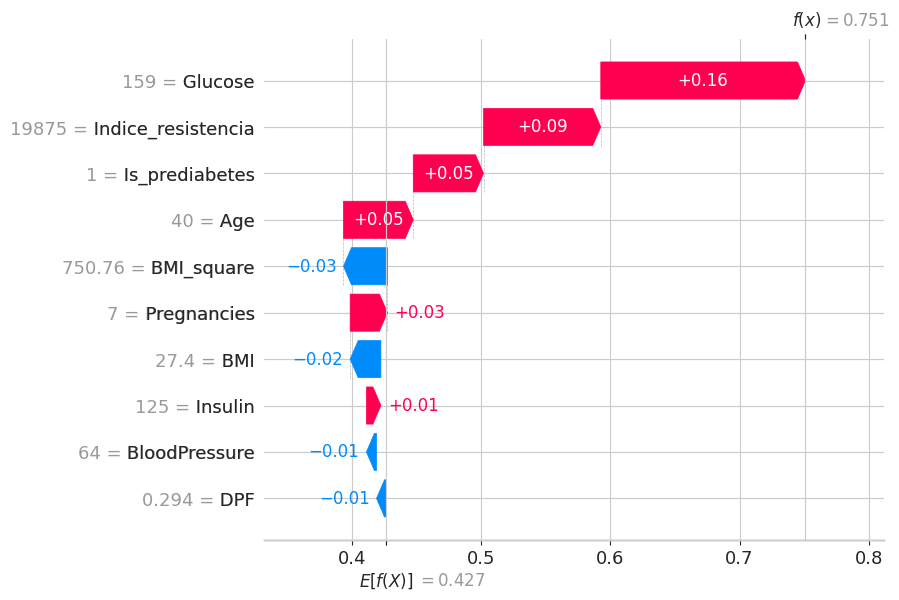

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EXPLICABILIDAD PACIENTE CONCRETO [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
instance_index = 0
shap_explanation_instance = shap_values[instance_index]
# Datos originales sin escalar
datos_originales = X_test_sin_NA.iloc[instance_index].values
# Reemplzamos los datos escalados por los originales (para ver valores coherentes)
shap_explanation_instance.data = datos_originales

shap.plots.waterfall(shap_explanation_instance, show=True)

### **6.- Guardar modelo**

In [ ]:
# Modelo seleccionado
rf_pipeline_final = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", RandomForestClassifier(class_weight="balanced", max_depth=5, min_samples_split=2, n_estimators=200, random_state = 7))
])
rf_pipeline_final.fit(X_train_val_sin_NA, y_train_val)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=7))])

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] EVALUACIÓN TEST MODELO ITERATIVO: 10 REPETICIONES [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
print(Panel(f"[bold {COLOR_PANEL}]  1) THRESHOLD ESTÁNDAR [/bold {COLOR_PANEL}]"))
df_test_05, curvas_05 = evaluar_modelo_iterativo(rf_pipeline_final, X_train_val_sin_NA, y_train_val, X_test_sin_NA, y_test, n_reps=10)
metrics_mean_05 = df_test_05.mean().round(3)
metrics_std_05  = df_test_05.std().round(3)
display(pd.DataFrame({"Media": metrics_mean_05, "Std": metrics_std_05}).T)

print(Panel(f"[bold {COLOR_PANEL}]  2) THRESHOLD ÓPTIMO [/bold {COLOR_PANEL}]"))
df_test_opt, curvas_opt = evaluar_modelo_iterativo(rf_pipeline_final, X_train_val_sin_NA, y_train_val, X_test_sin_NA, y_test, n_reps=10, threshold=0.27)
metrics_mean_opt = df_test_opt.mean().round(3)
metrics_std_opt = df_test_opt.std().round(3)
display(pd.DataFrame({"Media": metrics_mean_opt,"Std": metrics_std_opt}).T)

───────────────────────────────  EVALUACIÓN TEST MODELO ITERATIVO: 10 REPETICIONES  ───────────────────────────────

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   1) THRESHOLD ESTÁNDAR                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Accuracy  Precision  Recall     F2    AUC
Media     0.738      0.604   0.733  0.703  0.815
Std       0.009      0.010   0.018  0.015  0.003

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│   2) THRESHOLD ÓPTIMO                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Accuracy  Precision  Recall     F2    AUC
Media     0.719      0.560   0.924  0.818  0.815
Std       0.006      0.006   0.006  0.005  0.003

In [ ]:
console.rule(f"[bold {COLOR_CEMP}] GUARDAMOS EL MODELO [/bold {COLOR_CEMP}]", style=COLOR_TITULOS)
ruta_guardado = "modelos/"
if not os.path.exists(ruta_guardado):
    os.makedirs(ruta_guardado)
joblib.dump(rf_pipeline_final, os.path.join(ruta_guardado, "diabetes_rf_pipeline.pkl"))

print(f"Pipeline completo guardado exitosamente en: {ruta_guardado}diabetes_rf_pipeline.pkl")

──────────────────────────────────────────────  GUARDAMOS EL MODELO  ──────────────────────────────────────────────

Pipeline completo guardado exitosamente en: modelos/diabetes_rf_pipeline.pkl

In [ ]:
print(os.path.abspath(ruta_guardado))

/content/drive/MyDrive/Máster/Data/modelos

### **7.- Aplicacion web Streamlit**

Realizado desde git hub:
- https://tfm-mia-diabetes-nme-app.streamlit.app/